In [30]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np

In [26]:
from src.data_processor.phase_2.prob2.v1 import  Phase2Prob2FeatureProcessor
from src.drift_detector import drift_psi
from collections import Counter
# from src.data_processor.phase_2.prob1.v1 import Phase2Prob1FeatureProcessor
# from src.data_processor.phase_2.prob2.v1 import Phase2Prob2FeatureProcessor
from src.model_predictor import \
    (Phase1Prob1ModelPredictor, Phase1Prob2ModelPredictor, Phase2Prob1ModelPredictor, Phase2Prob2ModelPredictor)

In [5]:
DIR = 'D:/Workspace/test_phase2_prob2/'
files = os.listdir(DIR)

In [27]:
phase2_prob2_pretrained_model = Phase2Prob2ModelPredictor.from_pretrained('../checkpoints/phase-2/prob-2/v1.pkl')
phase2_prob2_feature_processor = Phase2Prob2FeatureProcessor()

In [24]:
train_df = pd.read_parquet("D:/Data/MLOPS_2023/data_phase-2/phase-2/prob-2/raw_train.parquet")

In [36]:
mapping_bla = {'Denial of Service':1,
 'Exploits':2,
 'Information Gathering':3,
 'Malware':4,
 'Normal':5,
 'Other':6}


In [40]:
valid_df = pd.concat(dfs)

In [43]:
train_df['label'] = 0

In [44]:
valid_df['label'] = 1

In [45]:
check_df = pd.concat([valid_df, train_df])

In [46]:
check_df['label'].value_counts()

1    412126
0     61841
Name: label, dtype: int64

In [47]:
new_df = phase2_prob2_feature_processor.transform(check_df)

In [74]:
HyperParameters={                 'n_estimators':100,
                 'learning_rate':0.1,
                 'max_depth':11,
                 'colsample_bytree':0.5,
                 'subsample':0.8,
                 'reg_alpha':1.2,
                 'reg_lambda':10,
                 'random_state':42,
                 'scale_pos_weight':3}
            
hyper_parameters = HyperParameters.copy()

In [75]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
FEATURES = phase2_prob2_feature_processor.data_features['features']
categorical = phase2_prob2_feature_processor.data_features['categorical_features']
TARGET = 'label'
from sklearn.metrics import accuracy_score,classification_report

In [76]:
from lightgbm import LGBMClassifier
TARGET = 'label'
# hyper_parameters['objective'] = 'multiclass'
models = []
scores = []
oofs = np.empty(check_df.shape[0], dtype='object')
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, check_df[TARGET])):
    # Xy_train = new_df.iloc[train_idx]
    # Xy_train['label'] = df.iloc[train_idx][TARGET]
    # Xy_train_NORMAL = Xy_train[Xy_train.label.apply(lambda x: x == 'Malware')]
    # Xy_train_NORMAL_sample = Xy_train_NORMAL.sample(frac=1, random_state=42)
    # # print(Xy_train_NORMAL_sample['label'].value_counts())
    # Xy_train_OTHER = Xy_train[Xy_train.label.apply(lambda x: x != 'Malware')]
    # Xy_train_sample = pd.concat([Xy_train_OTHER,Xy_train_NORMAL_sample])
    # Xy_train_sample = Xy_train_sample.sample(frac=1,random_state=123)
    # print(Xy_train_sample['label'].value_counts())

    X_train = new_df.iloc[train_idx]
    y_train = check_df.iloc[train_idx][TARGET]
    X_valid = new_df.iloc[valid_idx]
    y_valid = check_df.iloc[valid_idx][TARGET]


    print(X_train.shape, X_valid.shape)
    print(y_train.shape, y_valid.shape)
    model = LGBMClassifier(**hyper_parameters)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_metric=["logloss"],
              categorical_feature=categorical,
              early_stopping_rounds=50,
              verbose=50)
    # model = CatBoostClassifier(iterations=100, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42,eval_metric='AUC',class_weights={1:1.5,0:1})
    # model.fit(X_train, y_train,
    #           cat_features=categorical,
    #           eval_set=[(X_train, y_train), (X_valid, y_valid)])
    models.append(model)
    y_pred = model.predict(X_valid)
    oofs[valid_idx] = y_pred

    print(f"fold {i} : {accuracy_score(y_valid, y_pred)}")
    print(classification_report(y_valid, y_pred))
    scores.append(accuracy_score(y_valid, y_pred))

print(np.mean(scores), np.std(scores))
print(classification_report(list(check_df[TARGET].values), list(oofs)))
print(accuracy_score(list(check_df[TARGET].values), list(oofs)))

(379173, 37) (94794, 37)
(379173,) (94794,)


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgb

[50]	training's binary_logloss: 0.378286	valid_1's binary_logloss: 0.379834
[100]	training's binary_logloss: 0.369196	valid_1's binary_logloss: 0.372069
fold 0 : 0.8699390256767306
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     12368
           1       0.87      1.00      0.93     82426

    accuracy                           0.87     94794
   macro avg       0.93      0.50      0.47     94794
weighted avg       0.89      0.87      0.81     94794

(379173, 37) (94794, 37)
(379173,) (94794,)


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgb

[50]	training's binary_logloss: 0.378363	valid_1's binary_logloss: 0.380088
[100]	training's binary_logloss: 0.368412	valid_1's binary_logloss: 0.371736
fold 1 : 0.870023419203747
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     12369
           1       0.87      1.00      0.93     82425

    accuracy                           0.87     94794
   macro avg       0.93      0.50      0.47     94794
weighted avg       0.89      0.87      0.81     94794

(379174, 37) (94793, 37)
(379174,) (94793,)


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgb

[50]	training's binary_logloss: 0.377846	valid_1's binary_logloss: 0.379484
[100]	training's binary_logloss: 0.367975	valid_1's binary_logloss: 0.371778
fold 2 : 0.8698110619982489
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     12368
           1       0.87      1.00      0.93     82425

    accuracy                           0.87     94793
   macro avg       0.93      0.50      0.47     94793
weighted avg       0.89      0.87      0.81     94793

(379174, 37) (94793, 37)
(379174,) (94793,)


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgb

[50]	training's binary_logloss: 0.37748	valid_1's binary_logloss: 0.379139
[100]	training's binary_logloss: 0.368447	valid_1's binary_logloss: 0.371713
fold 3 : 0.8698427099047398
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     12368
           1       0.87      1.00      0.93     82425

    accuracy                           0.87     94793
   macro avg       0.93      0.50      0.47     94793
weighted avg       0.89      0.87      0.81     94793

(379174, 37) (94793, 37)
(379174,) (94793,)


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\lightgb

[50]	training's binary_logloss: 0.378872	valid_1's binary_logloss: 0.380861
[100]	training's binary_logloss: 0.368664	valid_1's binary_logloss: 0.372063
fold 4 : 0.8699271043220491
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     12368
           1       0.87      1.00      0.93     82425

    accuracy                           0.87     94793
   macro avg       0.93      0.50      0.47     94793
weighted avg       0.89      0.87      0.81     94793

0.869908664221103 7.524191266225792e-05
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     61841
           1       0.87      1.00      0.93    412126

    accuracy                           0.87    473967
   macro avg       0.93      0.50      0.47    473967
weighted avg       0.89      0.87      0.81    473967

0.8699086645272772


: 

In [67]:
check_df[TARGET]

0        1
1        1
2        1
3        1
4        1
        ..
61836    0
61837    0
61838    0
61839    0
61840    0
Name: label, Length: 473967, dtype: int64

In [37]:
dfs = []
predictions = []
for file in files:
    df = pd.read_csv(DIR+file)
    dfs.append(df)
    data = phase2_prob2_feature_processor.transform(df)
    prediction = phase2_prob2_pretrained_model.predict_proba(data)
    prediction = [mapping_bla[y] for y in prediction]
    predictions.append(prediction)

In [38]:
means = []
stds = []
for p in predictions:
    means.append(np.mean(p))
    stds.append(np.std(p))

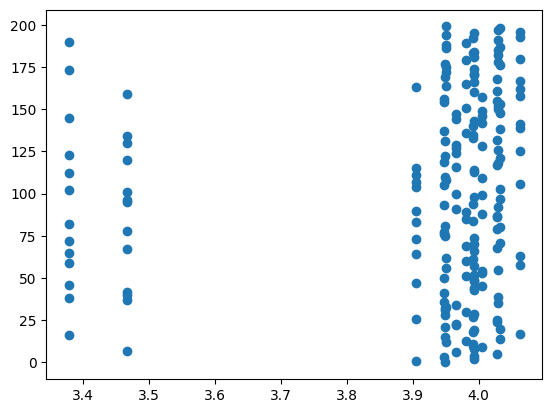

In [39]:
plt.scatter(x=means, y=np.arange(0, len(means)))

In [9]:
var_count_train = Counter(train_df['feature2'])

In [10]:
drift_dfs = []
for df in dfs:
    var_count_test = Counter(df['feature2'])
    if drift_psi(var_count_train, var_count_test) == 0:
        drift_dfs.append(df)

In [8]:
for df in drift_dfs:
    var_count_test = Counter(df['feature2'])
    print(var_count_test)

Counter({'tcp': 619, 'udp': 443, 'unas': 84, 'ospf': 21, 'arp': 15, 'qnx': 5, 'sctp': 5, 'mobile': 4, 'hmp': 3, 'idpr': 3, 'sun-nd': 2, 'gmtp': 2, 'il': 2, 'i-nlsp': 2, 'pup': 2, 'zero': 2, 'tlsp': 2, 'ip': 2, 'ipcomp': 2, 'tp++': 1, 'leaf-1': 1, 'wb-mon': 1, 'iso-ip': 1, 'ipx-n-ip': 1, 'ifmp': 1, 'iplt': 1, 'isis': 1, 'fc': 1, 'encap': 1, 'ipv6': 1, 'mfe-nsp': 1, 'vines': 1, 'etherip': 1, 'uti': 1, 'argus': 1, 'rsvp': 1, 'prm': 1, 'ttp': 1, 'kryptolan': 1, 'a/n': 1, 'sep': 1, 'ipcv': 1, 'merit-inp': 1, 'chaos': 1, 'fire': 1, 'leaf-2': 1, 'ggp': 1, 'xns-idp': 1, 'pipe': 1, 'trunk-1': 1, 'scps': 1, 'br-sat-mon': 1, 'ipv6-opts': 1, 'igp': 1, 'bna': 1, 'ax.25': 1, 'dcn': 1, 'egp': 1, 'mhrp': 1, 'pnni': 1, 'dgp': 1, 'any': 1, 'idrp': 1, 'ipv6-no': 1, 'micp': 1, 'cbt': 1, 'cpnx': 1})
Counter({'tcp': 452, 'udp': 398, 'unas': 52, 'arp': 20, 'ospf': 12, 'sctp': 10, 'sun-nd': 4, 'rsvp': 3, 'netblt': 2, 'sdrp': 2, 'idpr': 2, 'mobile': 2, 'sep': 2, 'qnx': 2, 'rvd': 2, 'ggp': 2, 'secure-vmtp': 2, 

In [9]:
var_count_train

Counter({'tcp': 29587,
         'udp': 22189,
         'unas': 3754,
         'arp': 888,
         'ospf': 802,
         'sctp': 318,
         'any': 92,
         'gre': 74,
         'ipv6': 72,
         'pim': 64,
         'swipe': 61,
         'mobile': 60,
         'sep': 59,
         'rsvp': 56,
         'sun-nd': 54,
         'mtp': 44,
         'tcf': 44,
         'emcon': 43,
         'pipe': 43,
         'ip': 41,
         'sat-expak': 41,
         'narp': 41,
         'visa': 40,
         'trunk-2': 39,
         'sprite-rpc': 39,
         'vines': 39,
         'ifmp': 39,
         'iso-ip': 38,
         'ptp': 38,
         'ipcomp': 38,
         'fc': 38,
         'ipv6-opts': 38,
         'ipcv': 38,
         'wsn': 37,
         'micp': 37,
         'etherip': 37,
         'stp': 36,
         'cbt': 36,
         'eigrp': 36,
         'pri-enc': 36,
         'qnx': 36,
         'sm': 36,
         'sat-mon': 36,
         'sccopmce': 35,
         'egp': 35,
         'ipv6-route'

In [10]:
train_df['feature2'].value_counts()

tcp       29587
udp       22189
unas       3754
arp         888
ospf        802
          ...  
idrp         22
isis         22
netblt       22
igmp          5
icmp          3
Name: feature2, Length: 132, dtype: int64

In [11]:
m_cat = []
for k,v in var_count_train.items():
    if v < 20:
        m_cat.append(k)

In [12]:
'tp++' in var_count_train

True

In [13]:
top_cat = []
for k,v in var_count_train.items():
    if v >= 40:
        top_cat.append(k)

In [14]:
var_count_train

Counter({'tcp': 29587,
         'udp': 22189,
         'unas': 3754,
         'arp': 888,
         'ospf': 802,
         'sctp': 318,
         'any': 92,
         'gre': 74,
         'ipv6': 72,
         'pim': 64,
         'swipe': 61,
         'mobile': 60,
         'sep': 59,
         'rsvp': 56,
         'sun-nd': 54,
         'mtp': 44,
         'tcf': 44,
         'emcon': 43,
         'pipe': 43,
         'ip': 41,
         'sat-expak': 41,
         'narp': 41,
         'visa': 40,
         'trunk-2': 39,
         'sprite-rpc': 39,
         'vines': 39,
         'ifmp': 39,
         'iso-ip': 38,
         'ptp': 38,
         'ipcomp': 38,
         'fc': 38,
         'ipv6-opts': 38,
         'ipcv': 38,
         'wsn': 37,
         'micp': 37,
         'etherip': 37,
         'stp': 36,
         'cbt': 36,
         'eigrp': 36,
         'pri-enc': 36,
         'qnx': 36,
         'sm': 36,
         'sat-mon': 36,
         'sccopmce': 35,
         'egp': 35,
         'ipv6-route'

In [15]:
for cat in m_cat:
    print('='*10+cat)
    print(train_df[train_df['feature2'] == cat]['label'].value_counts())

==========igmp
Normal    5
Name: label, dtype: int64
==========icmp
Normal    3
Name: label, dtype: int64


In [15]:
check_drift = {}
for col in ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
            'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
            'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
            'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
            'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
            'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
            'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
            'feature37', 'feature38', 'feature39', 'feature40', 'feature41']:
    if col not in ["feature2",
                   "feature3",
                   "feature4"]:
        print(col)
        mean_ = []
        std_ = []
        max_ = []
        min_ = []
        n_maxs = []
        n_mins = []
        train_max = train_df[col].max()
        train_min = train_df[col].min()
        for df in dfs:
            mean_.append(df[col].mean())
            std_.append(df[col].std())
            max_.append(df[col].max())
            min_.append(df[col].min())
            n_maxs.append(df[df[col]>train_max].shape[0])
            n_mins.append(df[df[col]<train_min].shape[0])
        check_drift[col] = pd.DataFrame({'mean_':mean_, 'std_':std_, 'max_': max_, 'min_':min_, 'n_max':n_maxs, 'n_min':n_mins})

feature1
feature5
feature6
feature7
feature8
feature9
feature10
feature11
feature12
feature13
feature14
feature15
feature16
feature17
feature18
feature19
feature20
feature21
feature22
feature23
feature24
feature25
feature26
feature27
feature28
feature29
feature30
feature31
feature32
feature33
feature34
feature35
feature36
feature37
feature38
feature39
feature40
feature41


In [16]:
import matplotlib.pyplot as plt

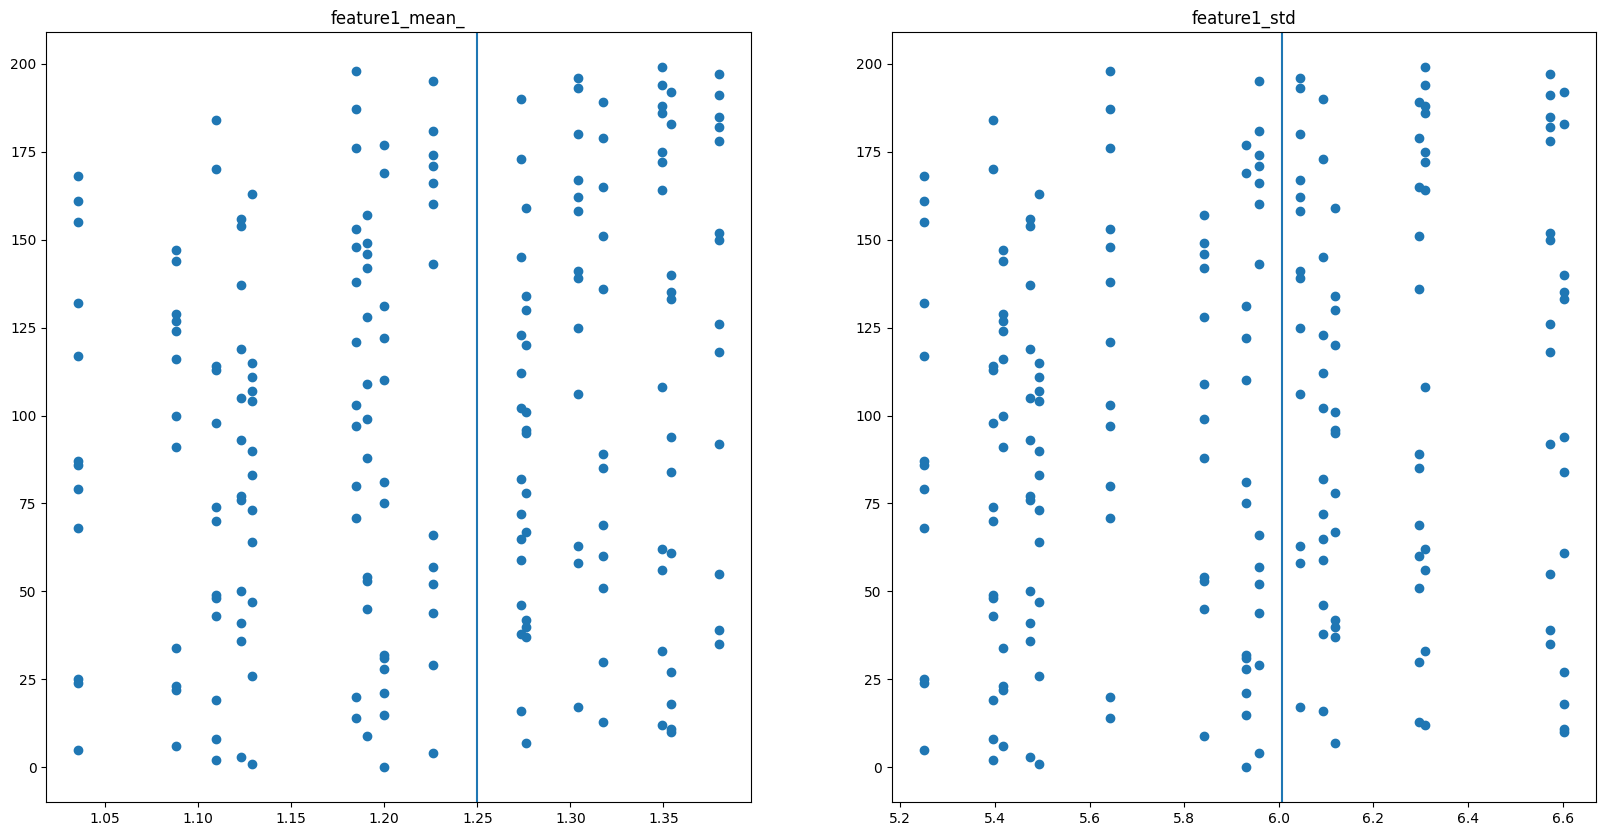

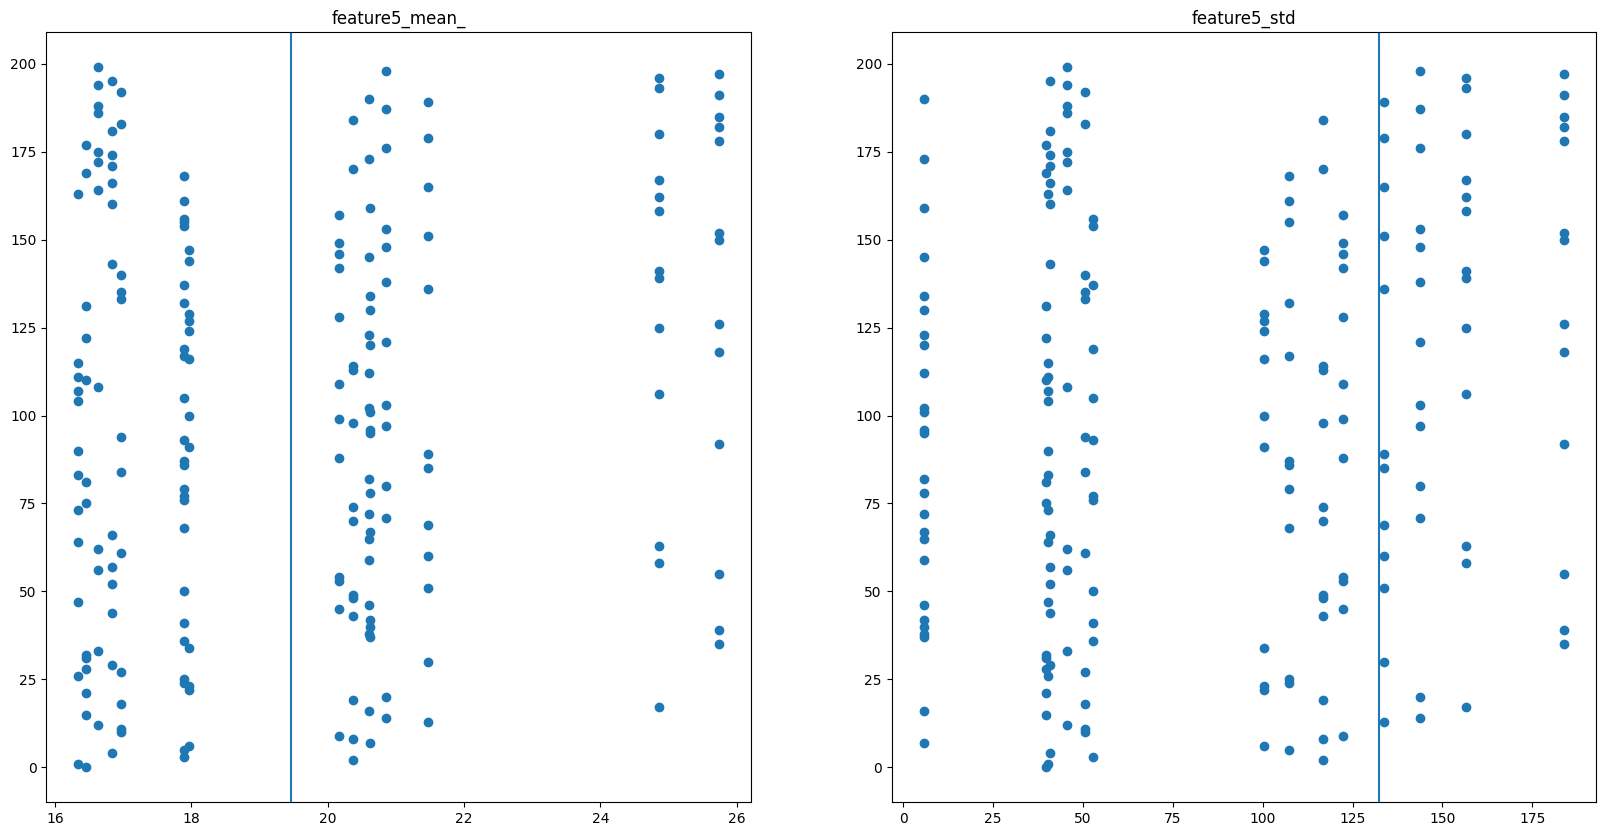

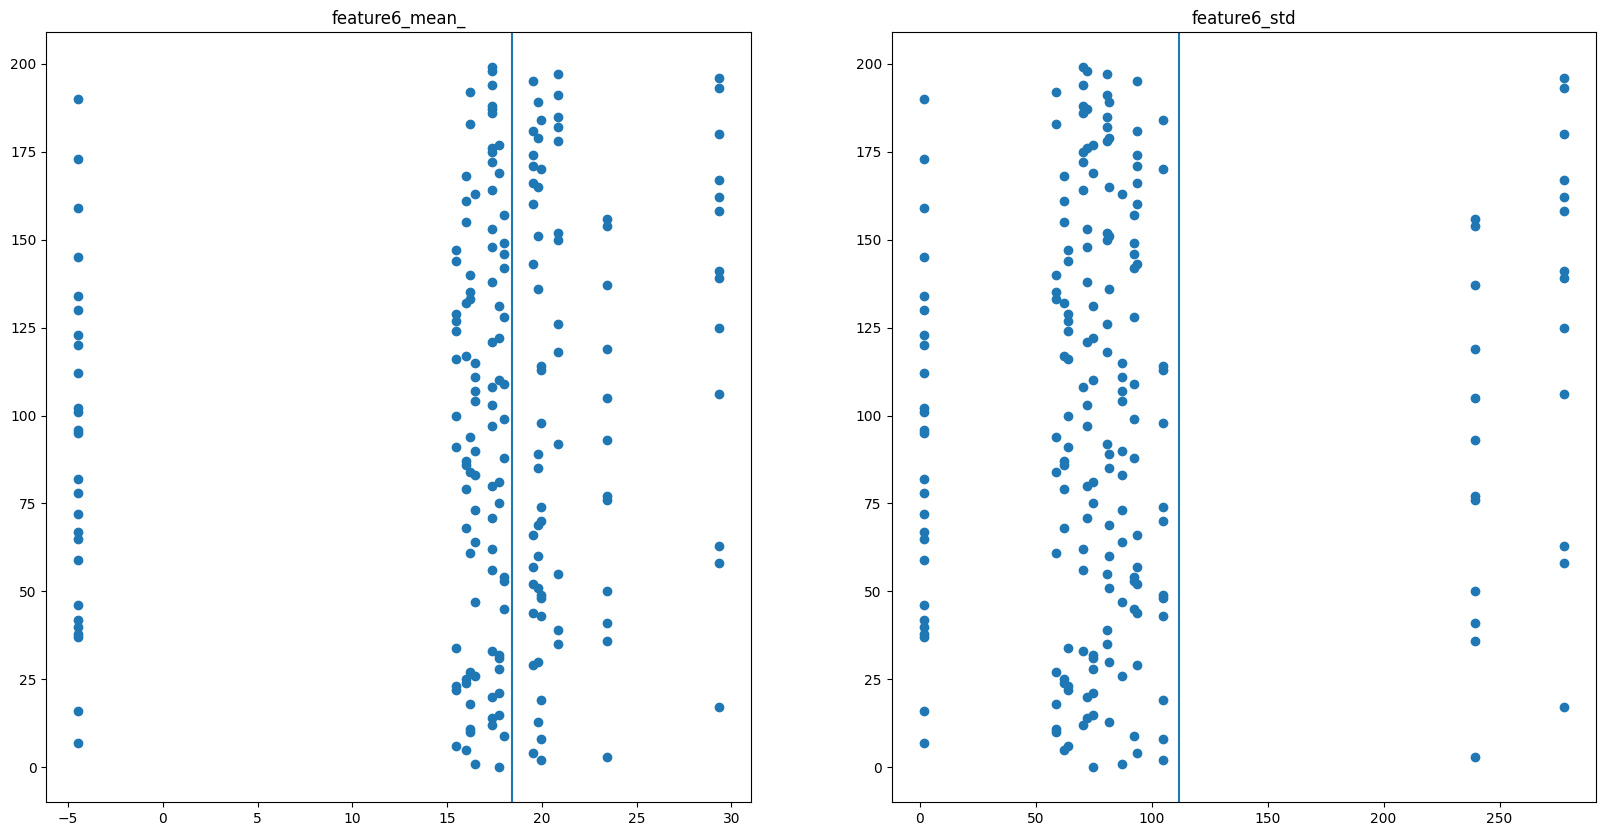

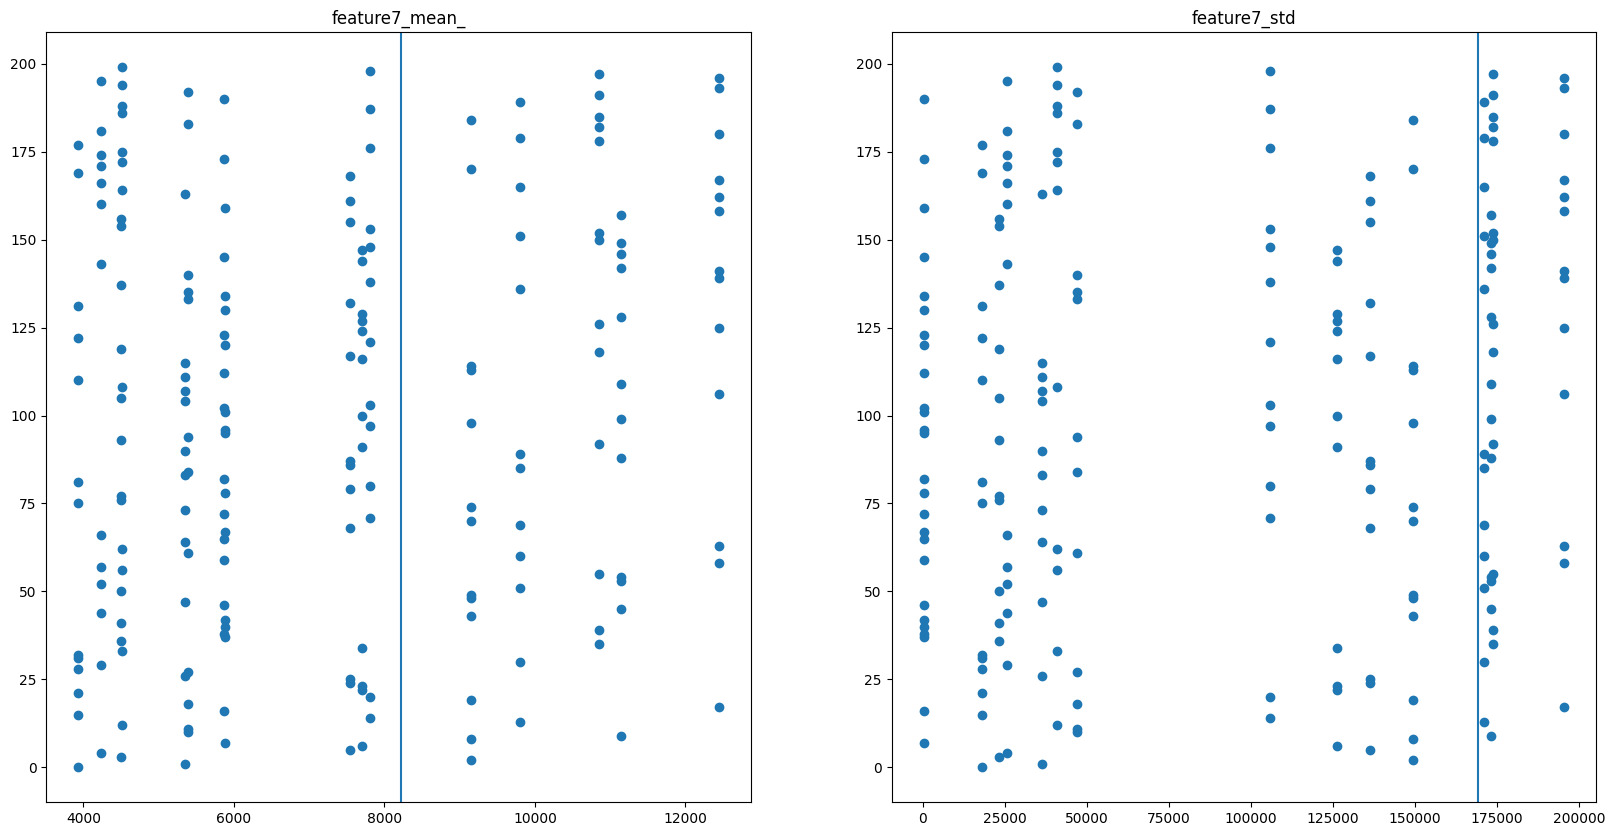

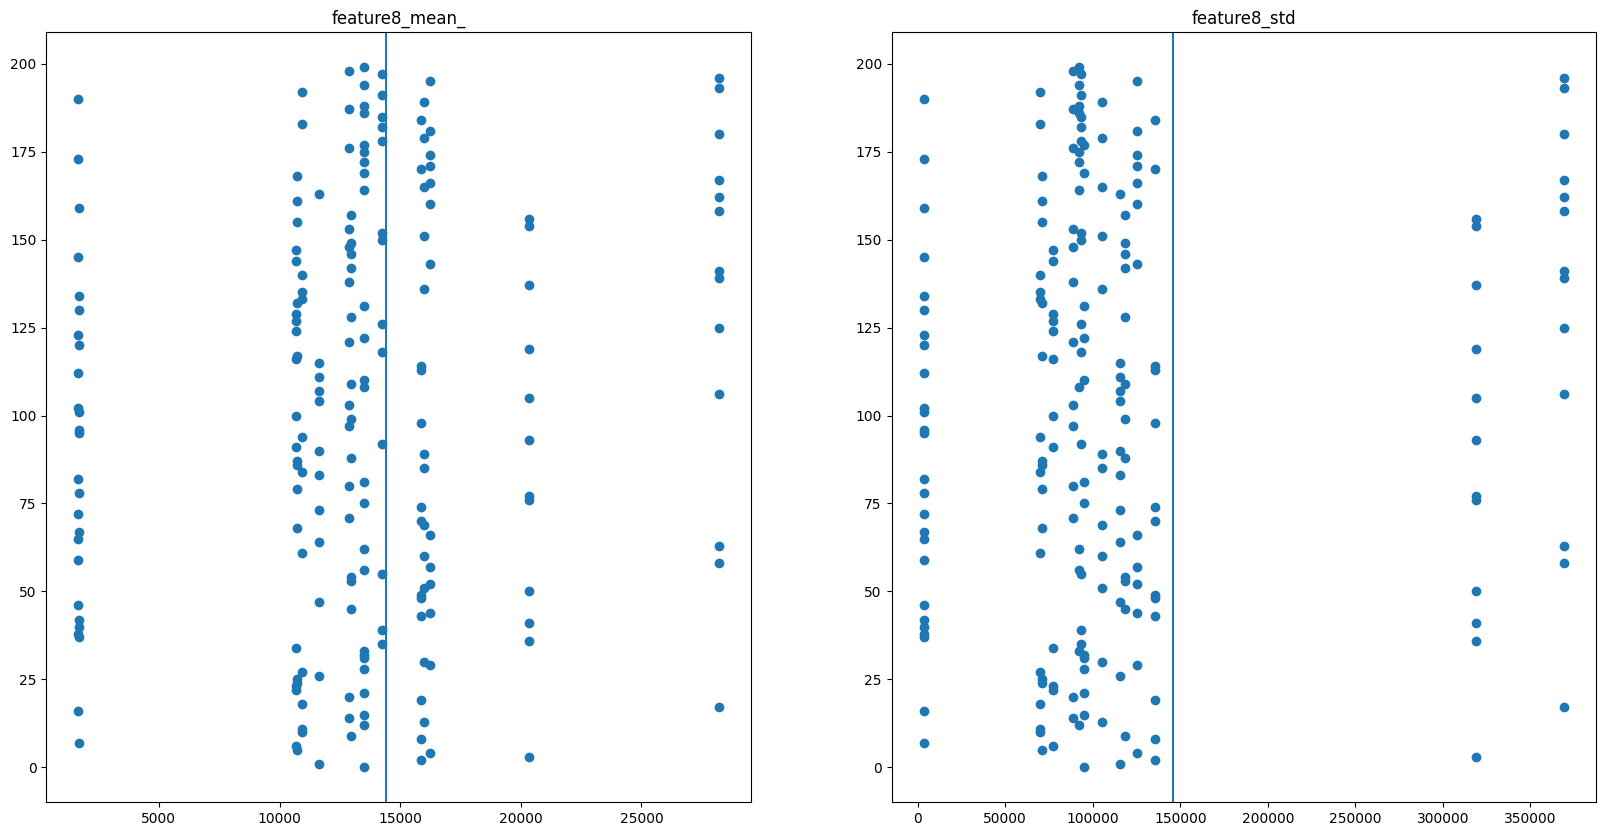

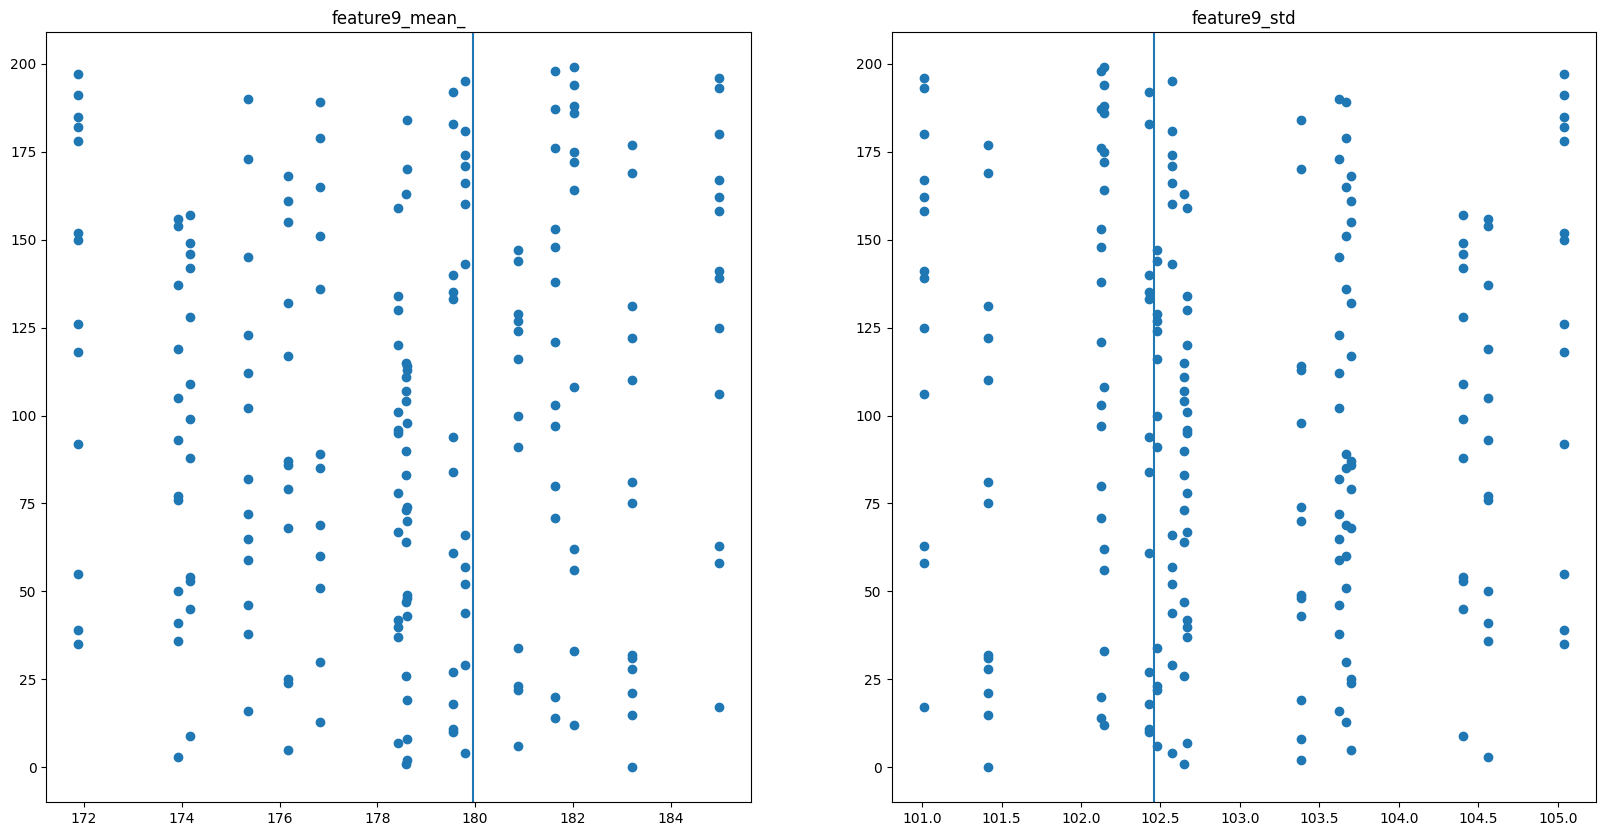

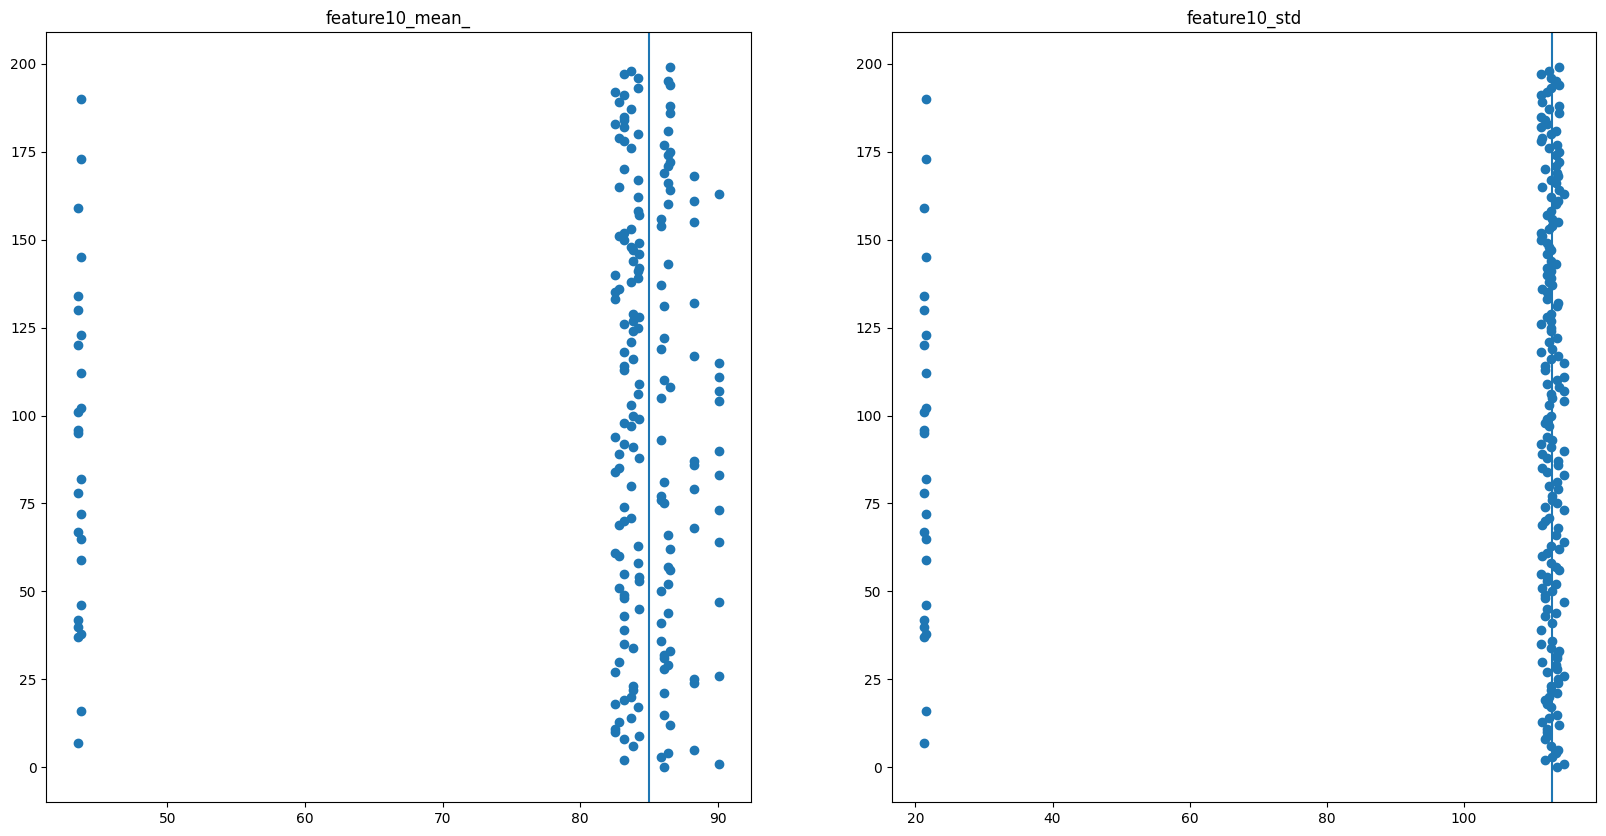

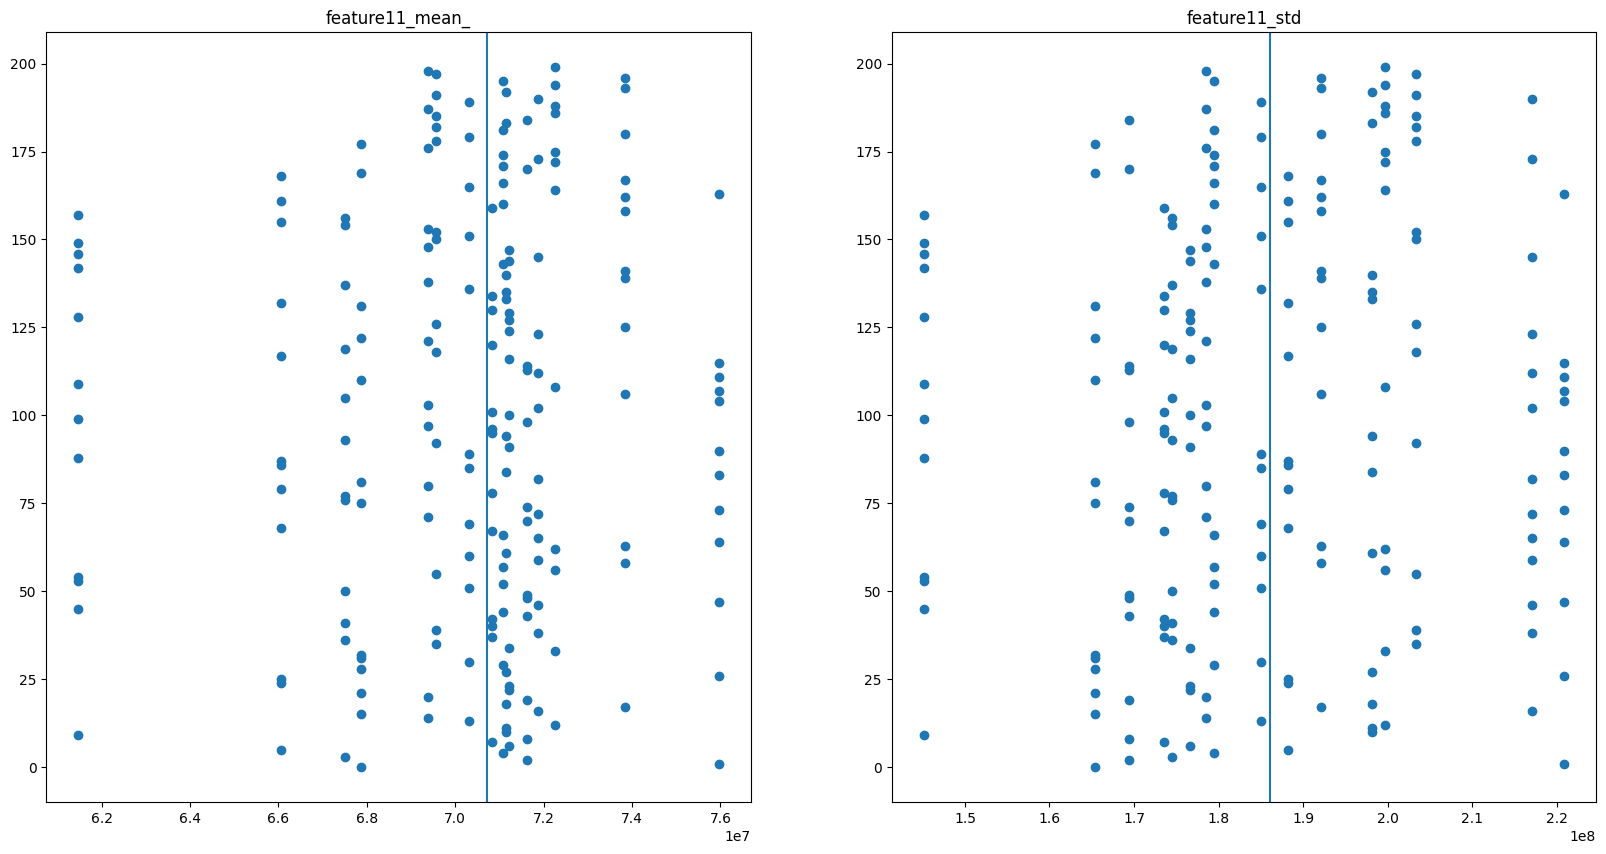

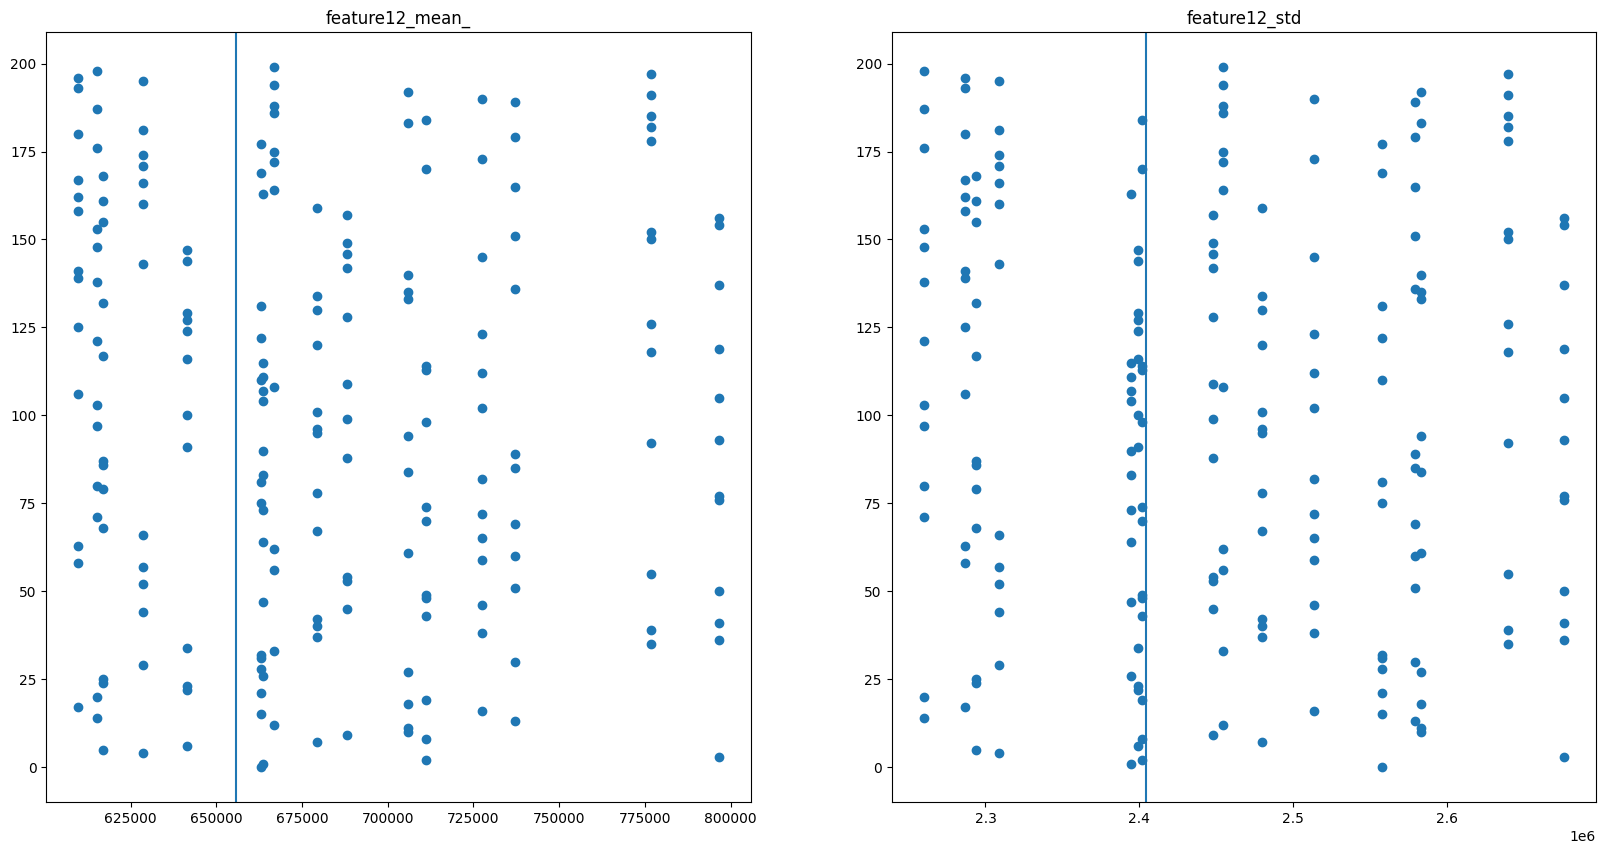

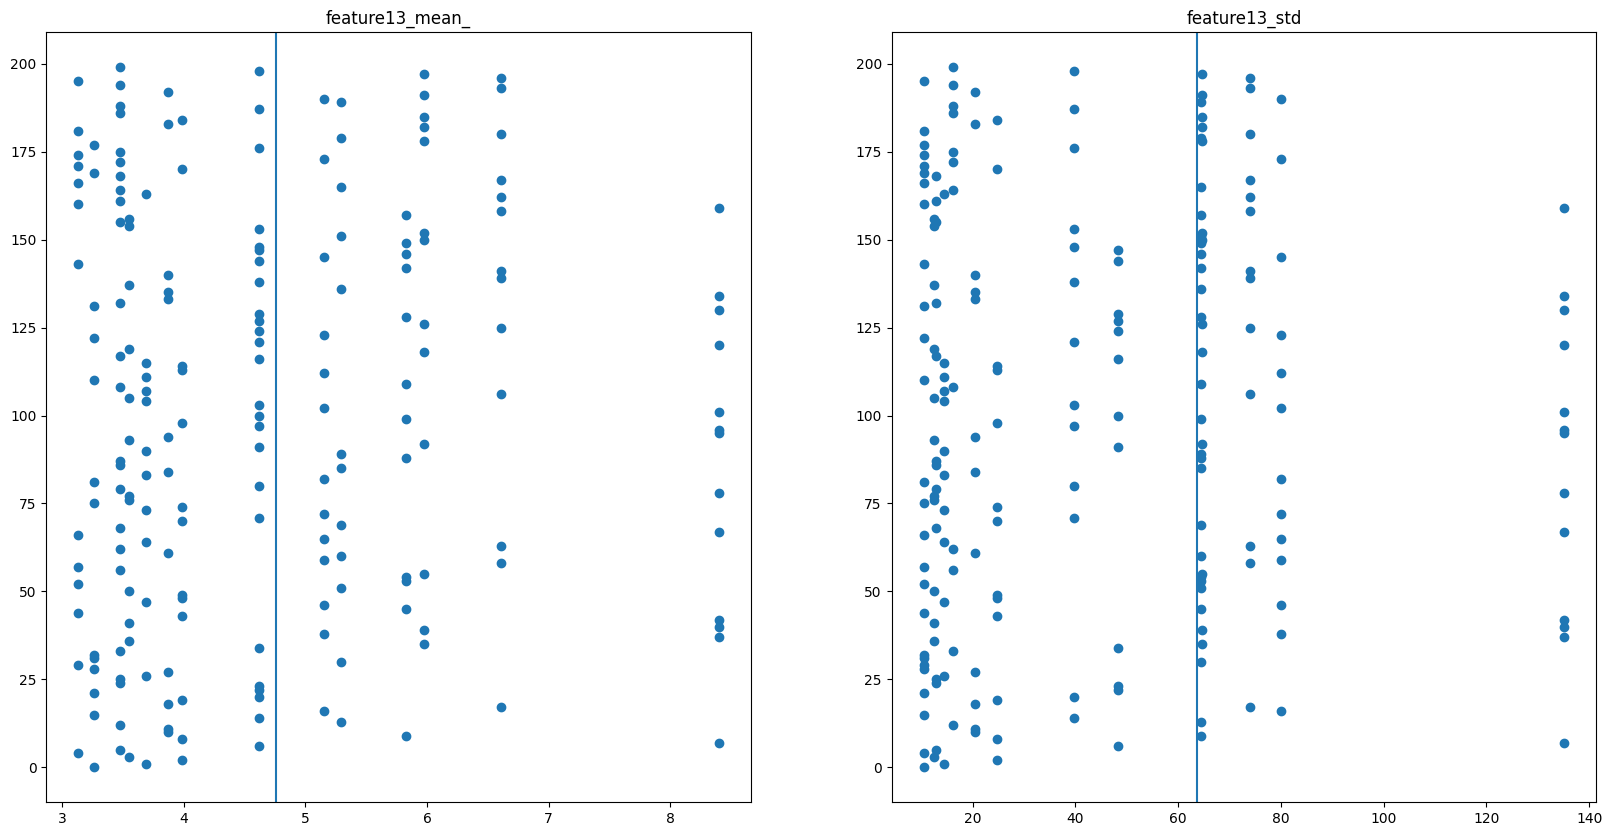

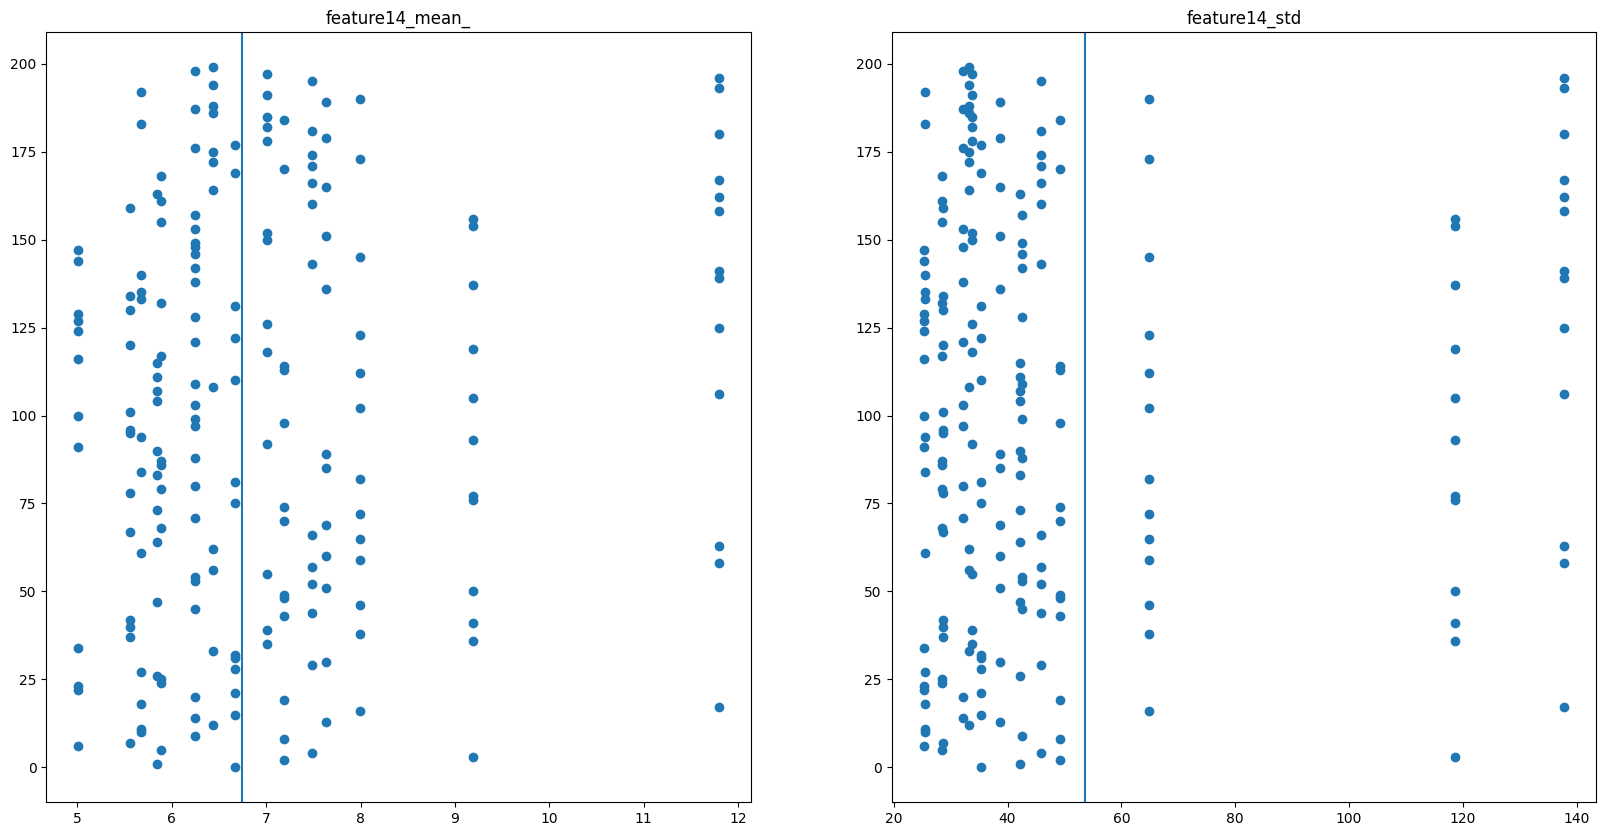

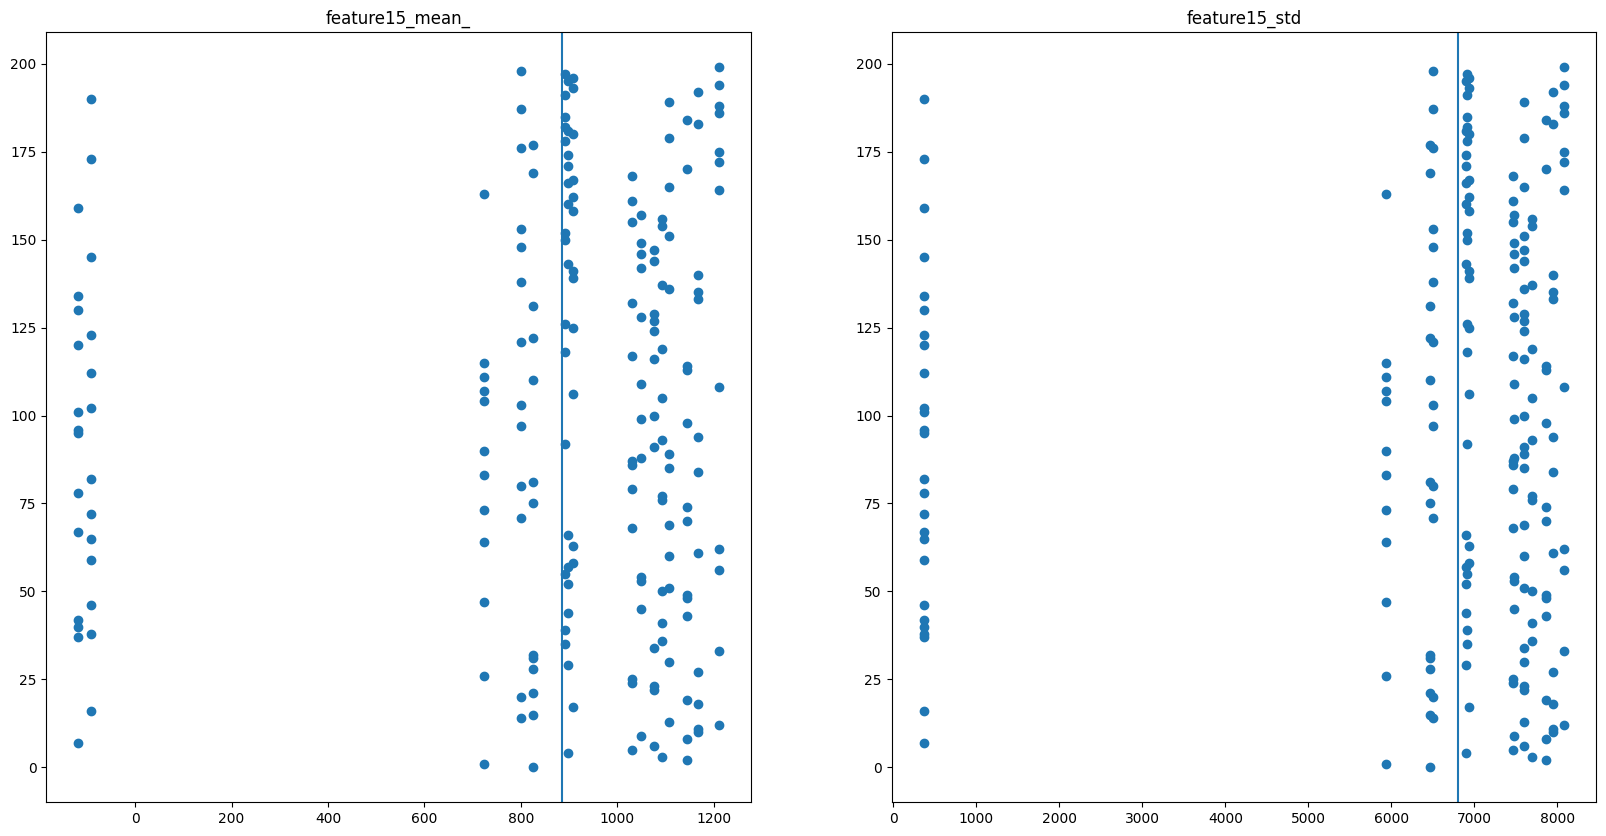

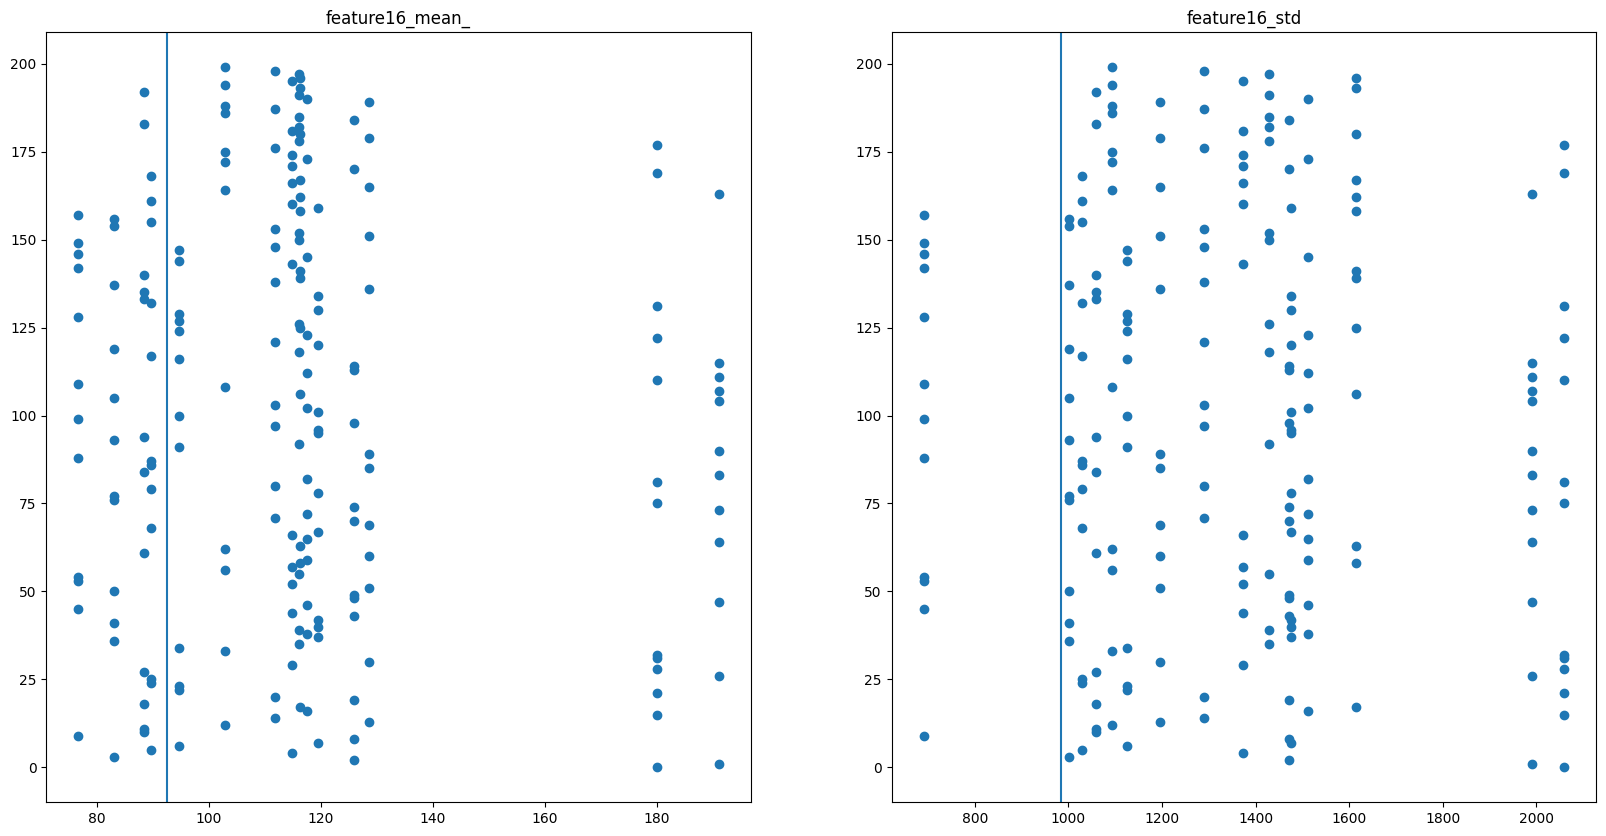

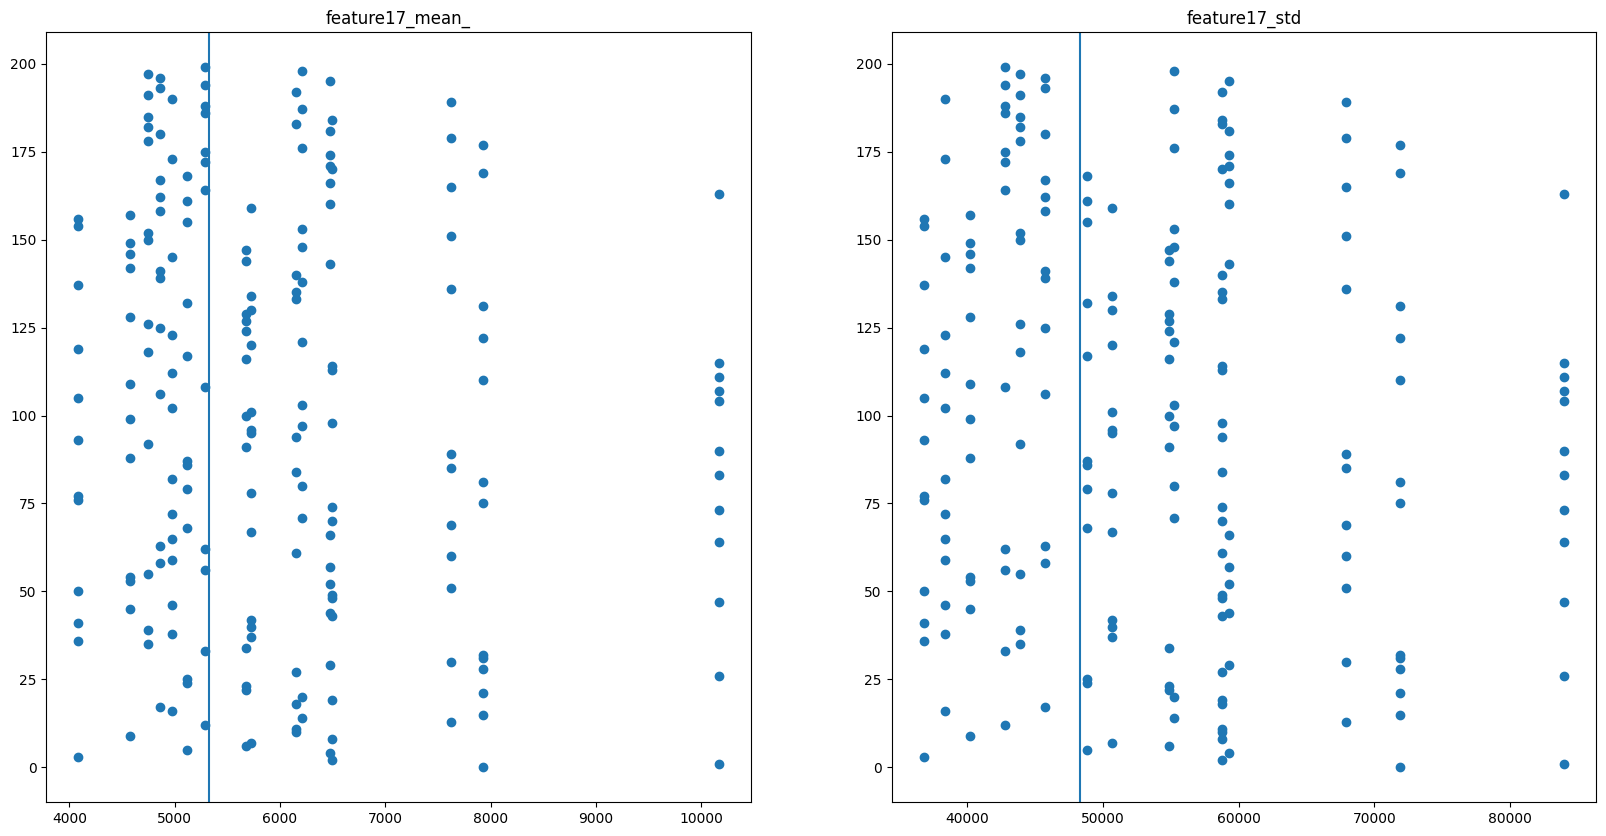

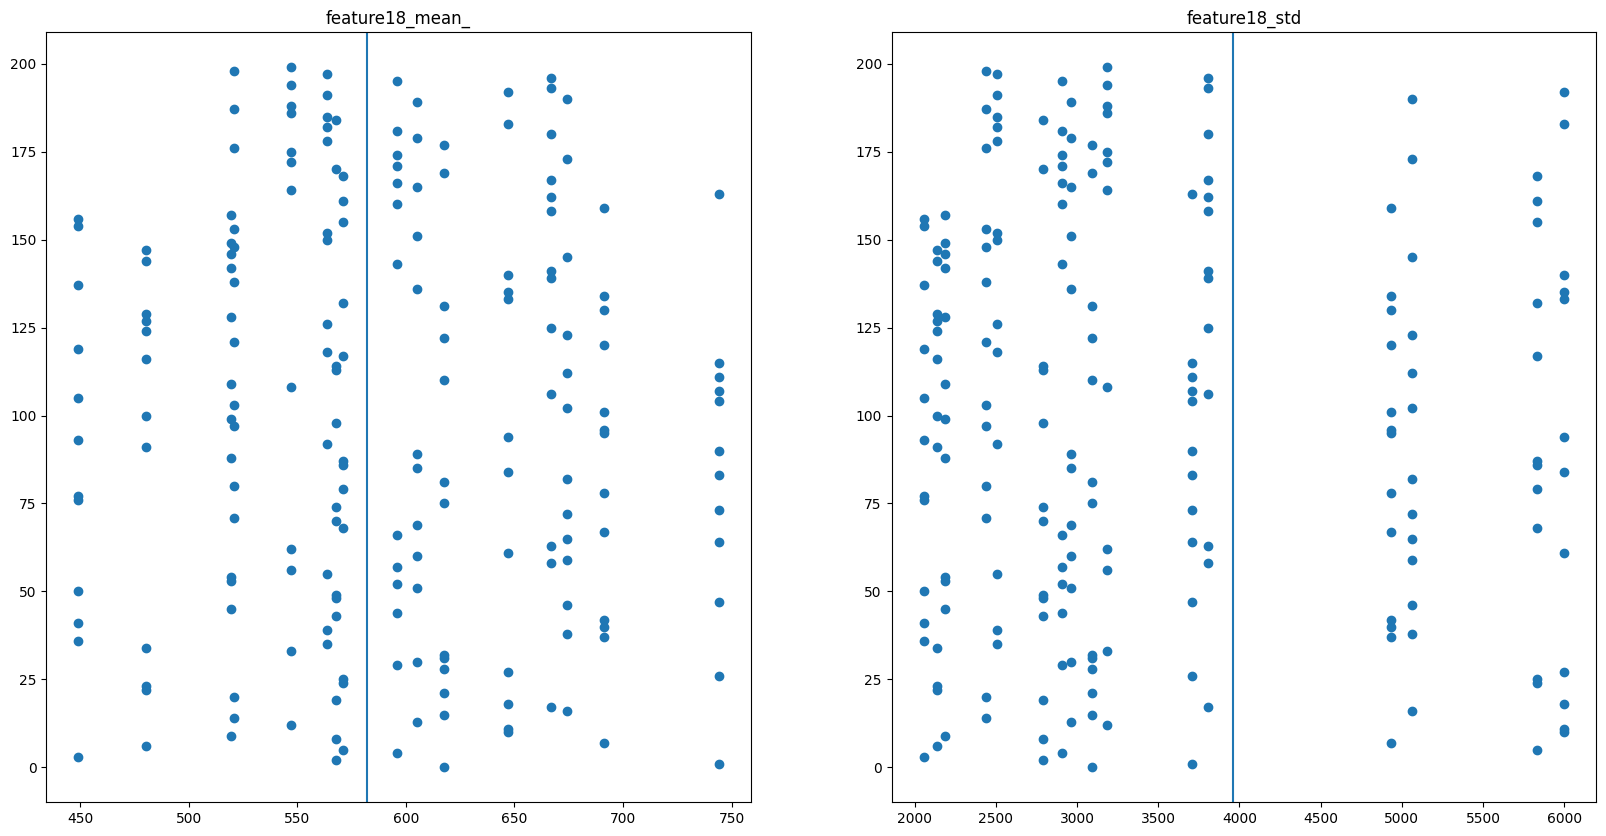

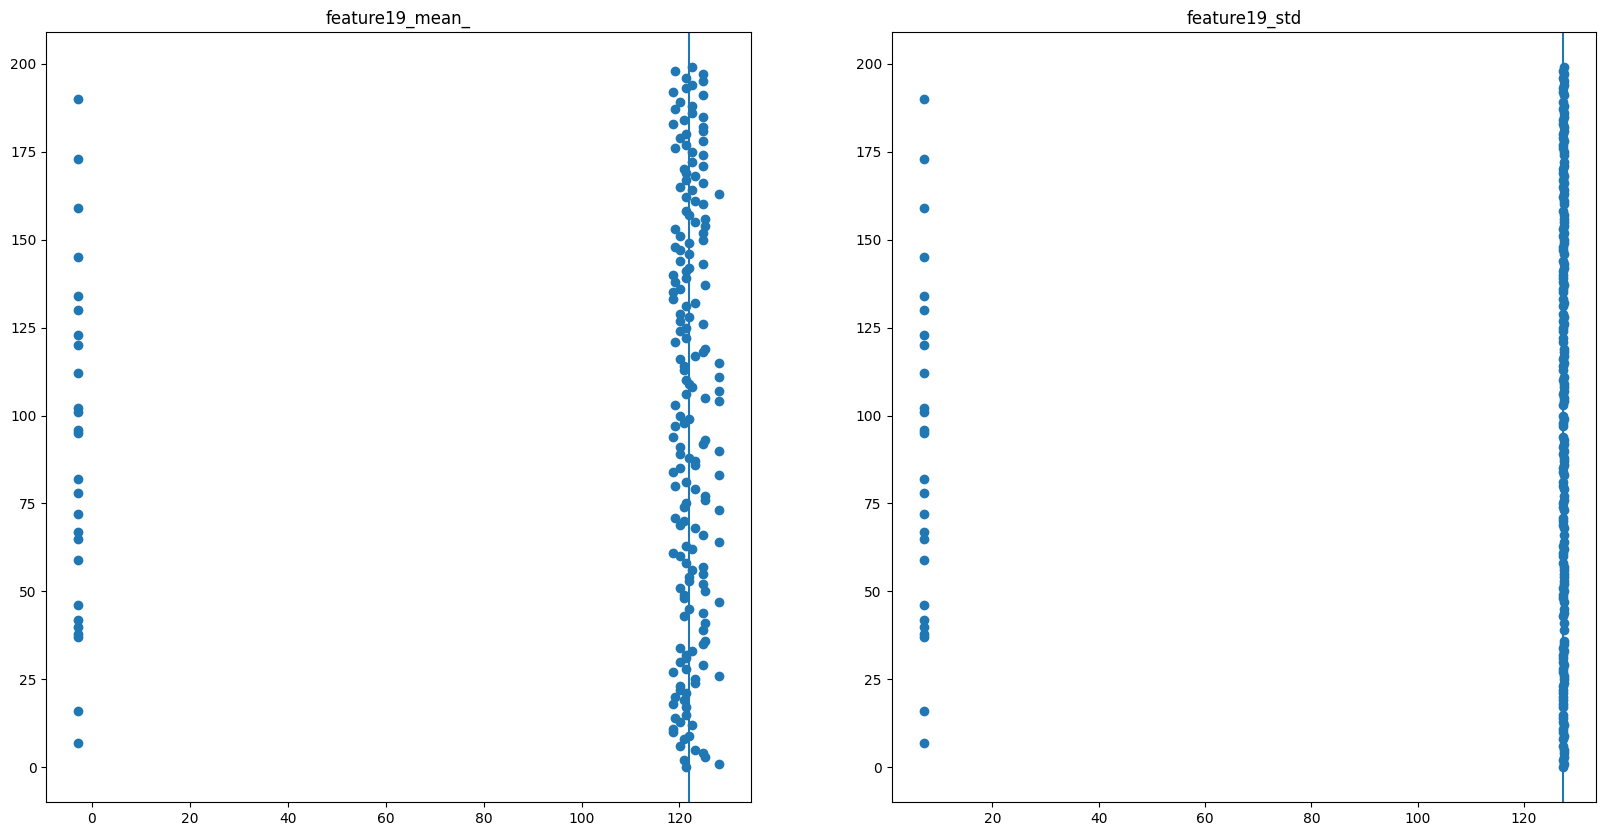

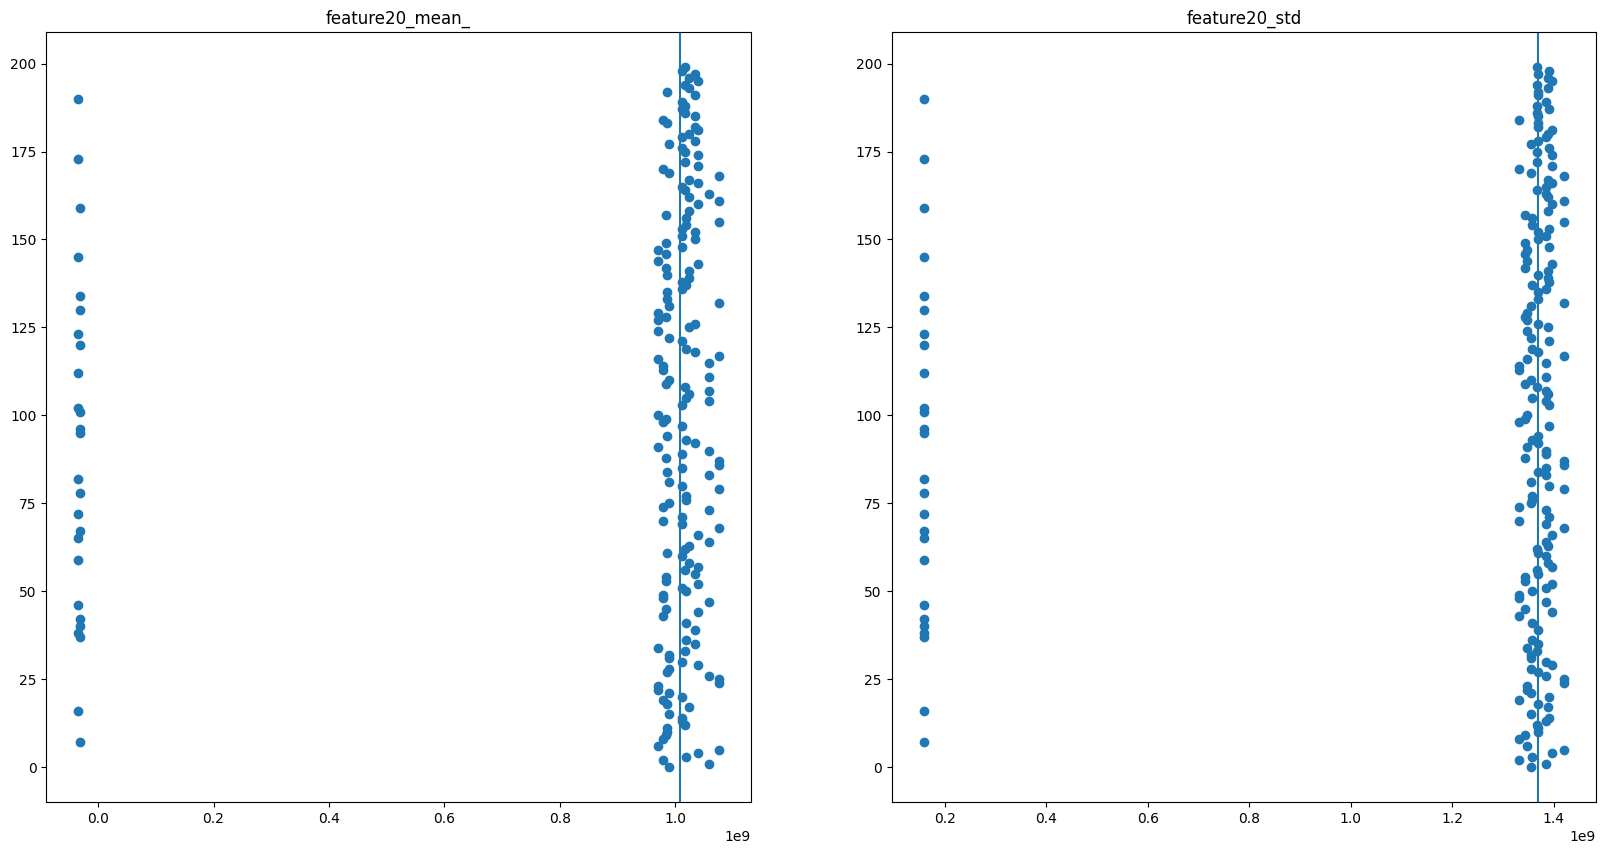

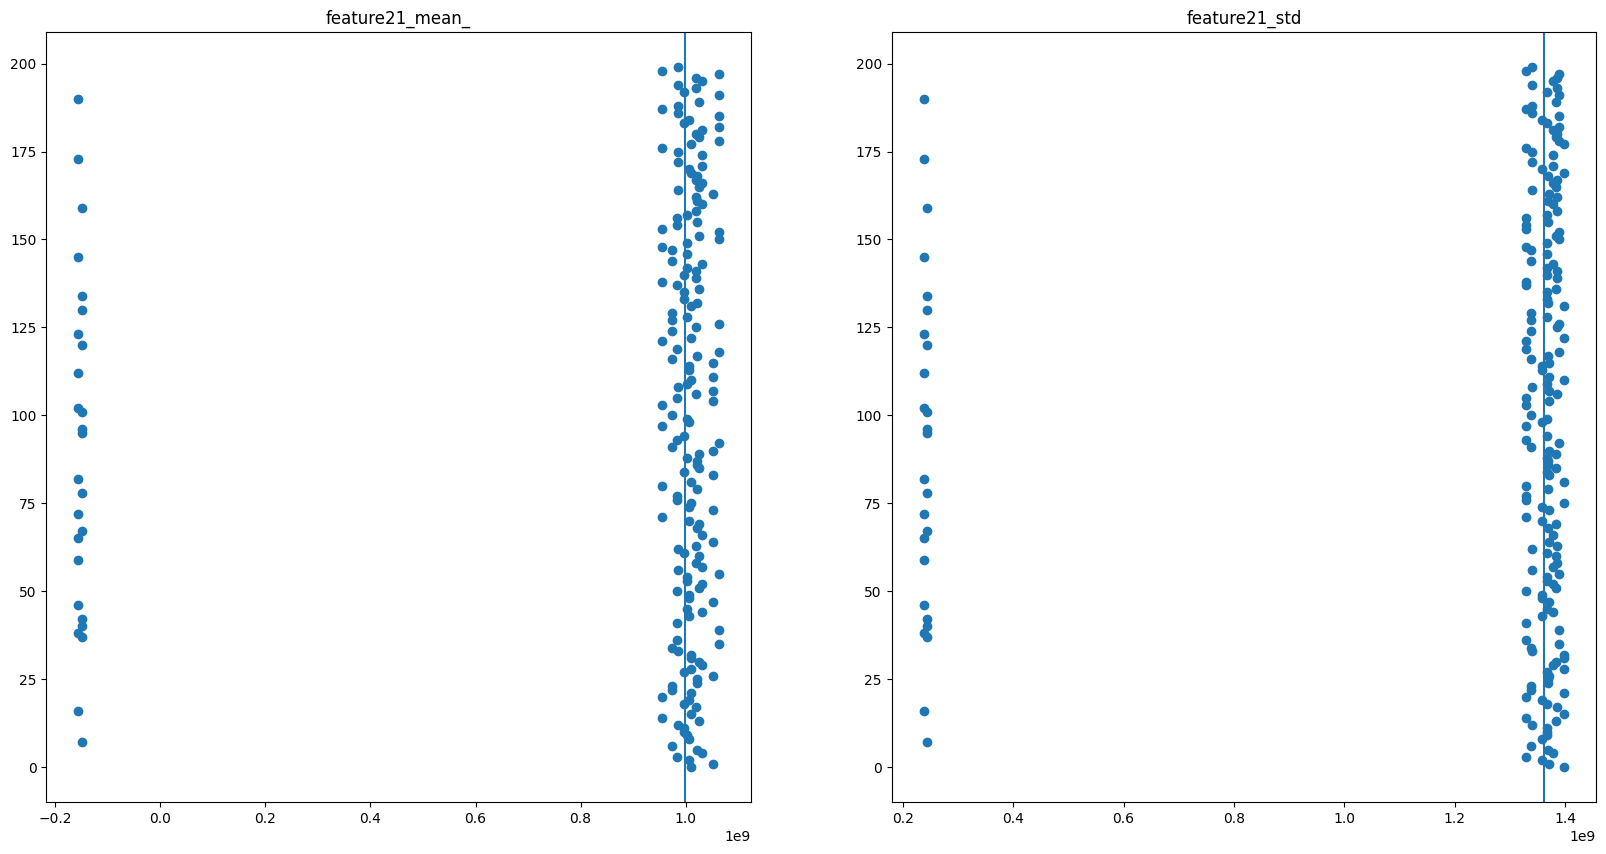

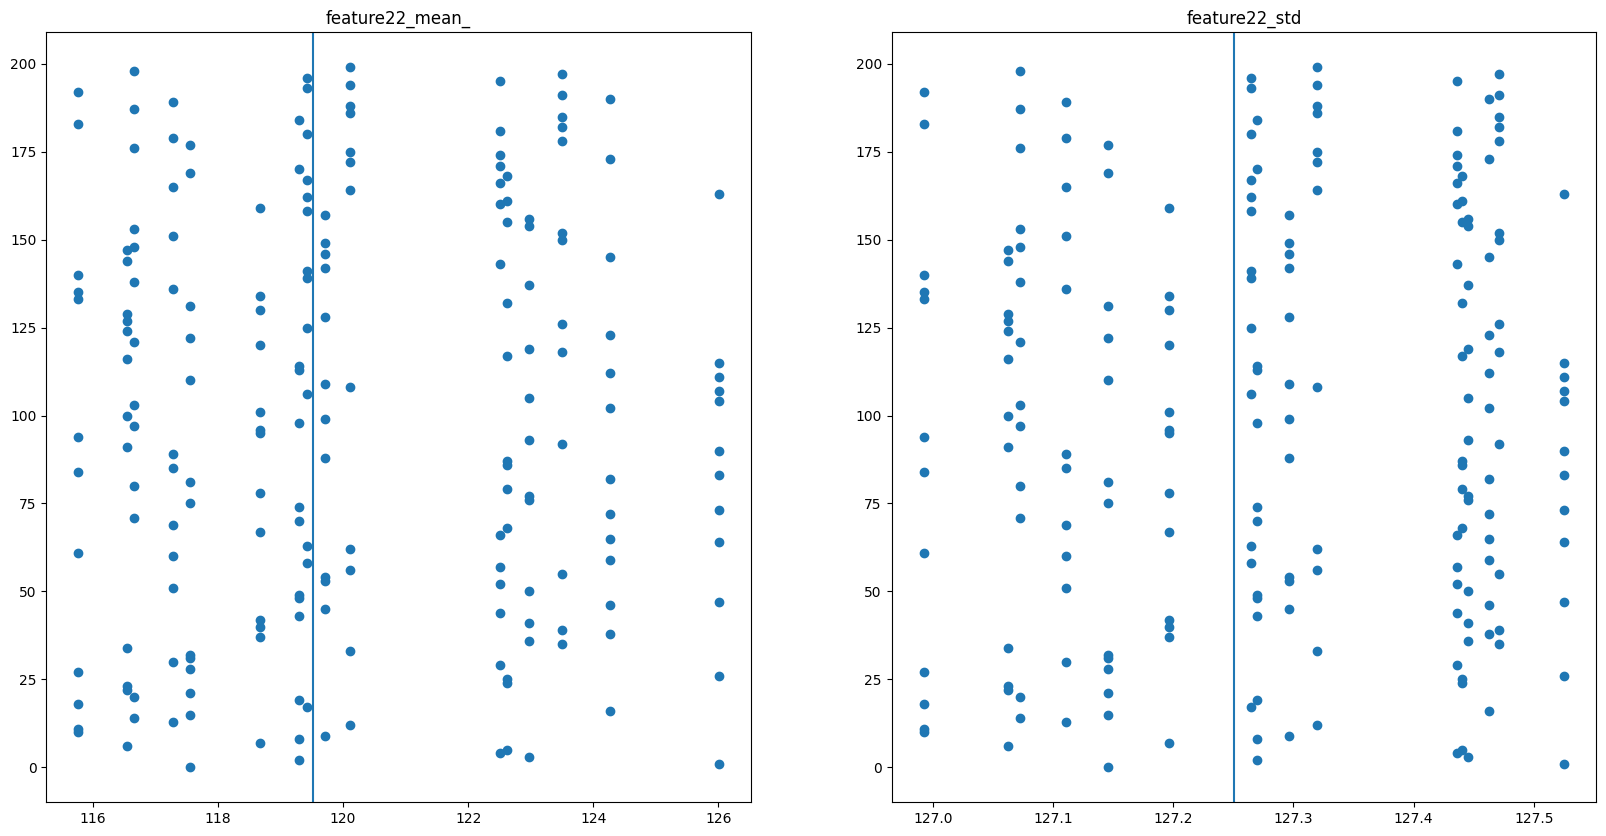

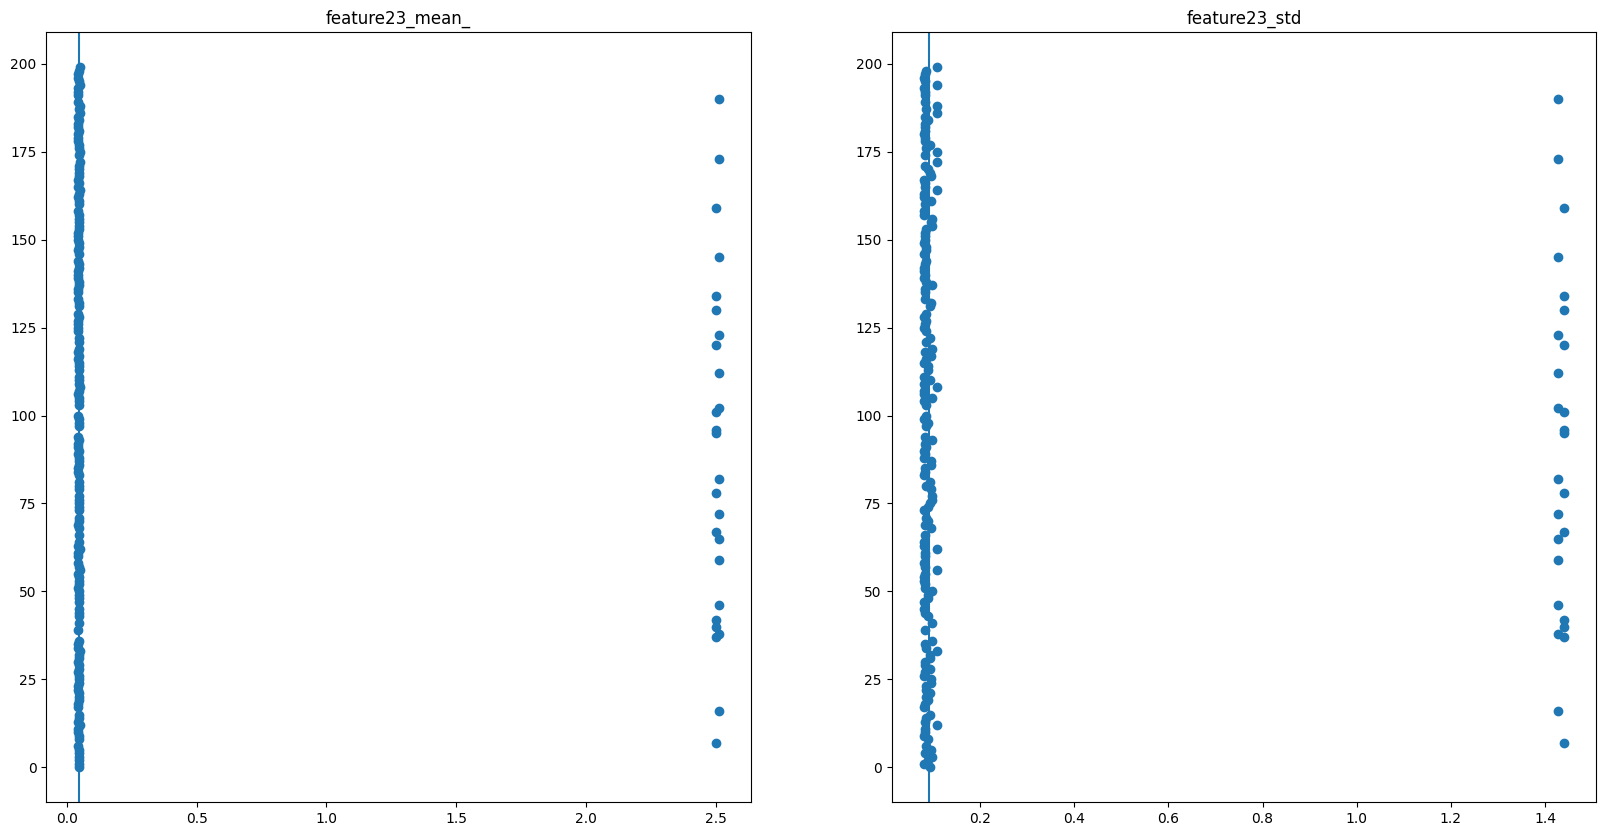

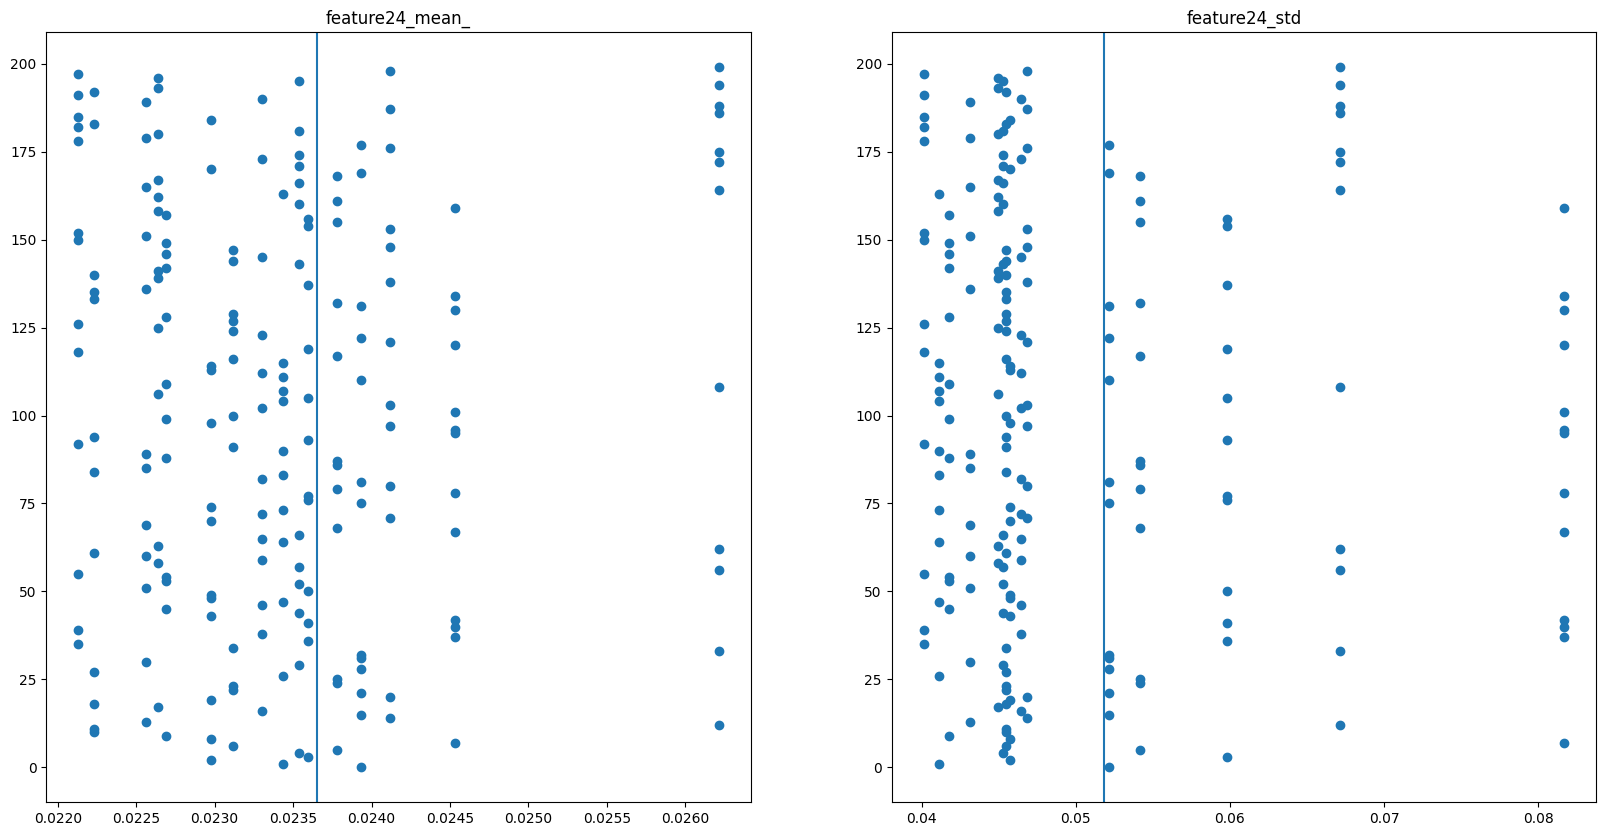

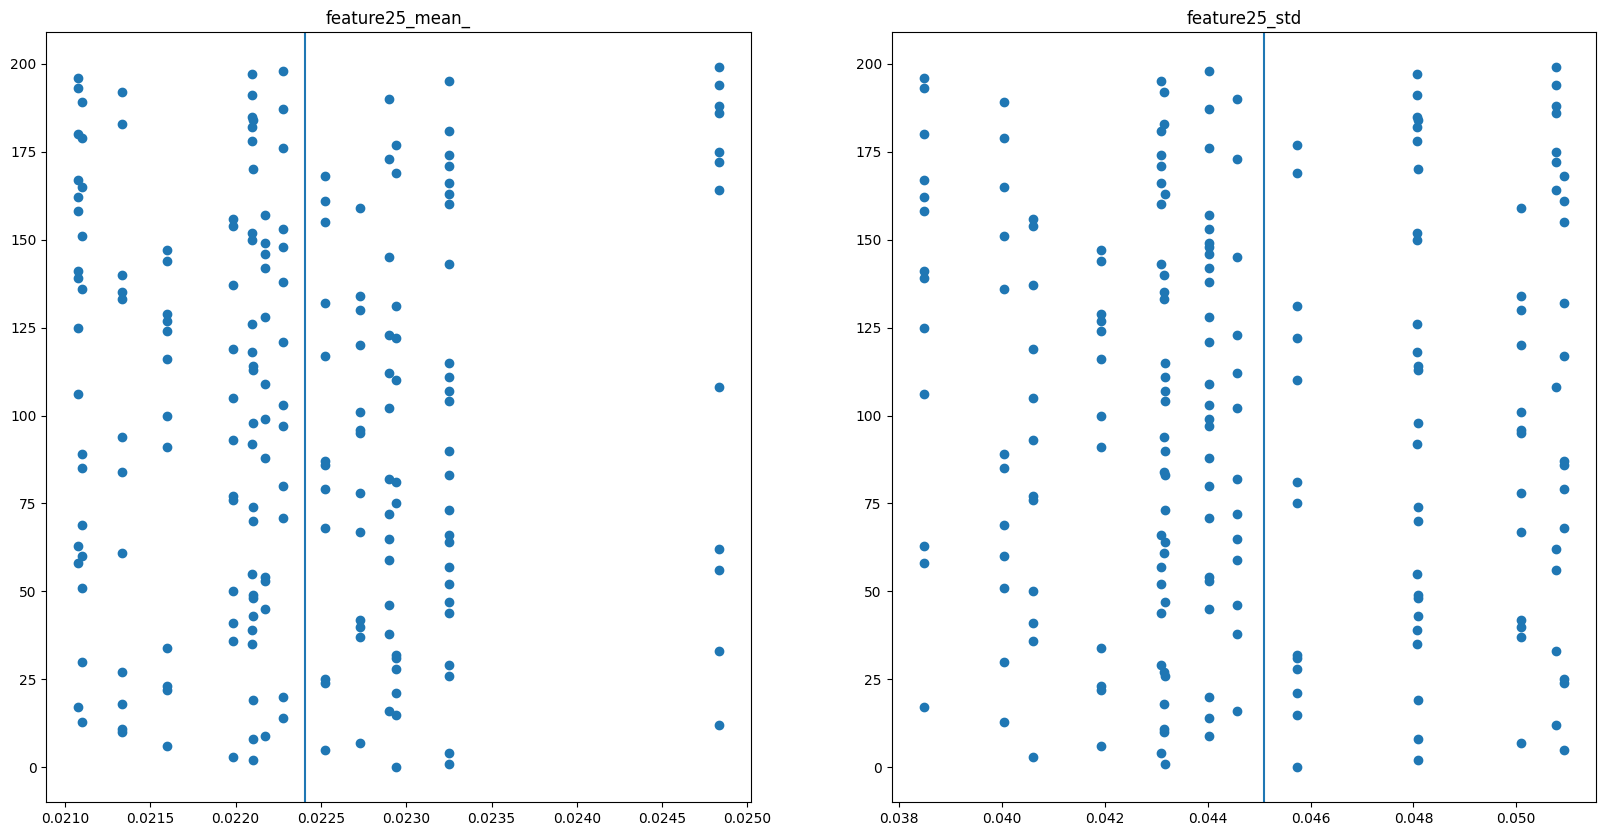

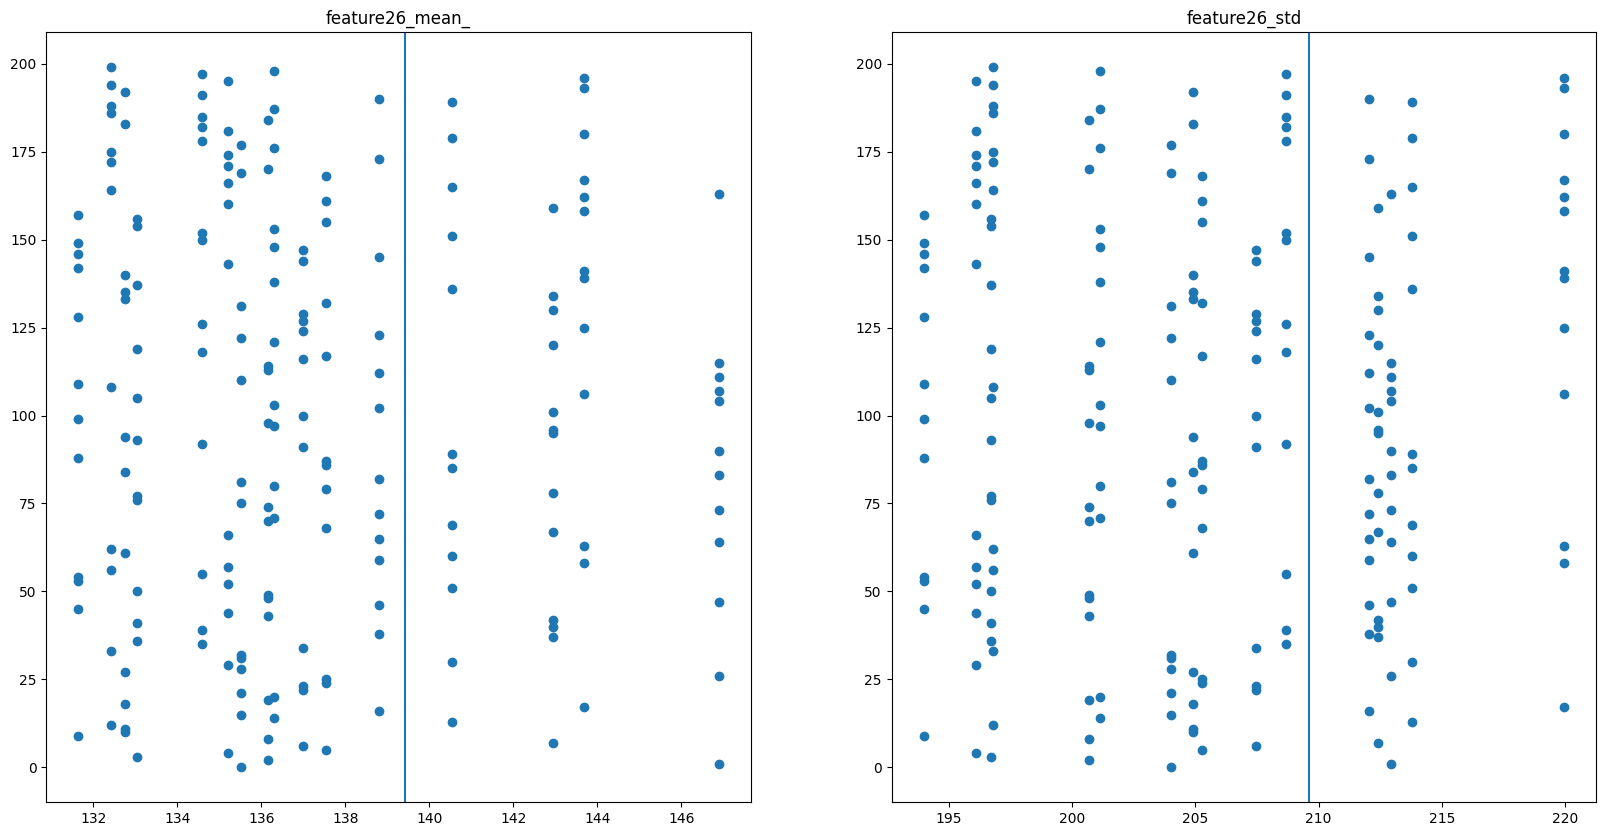

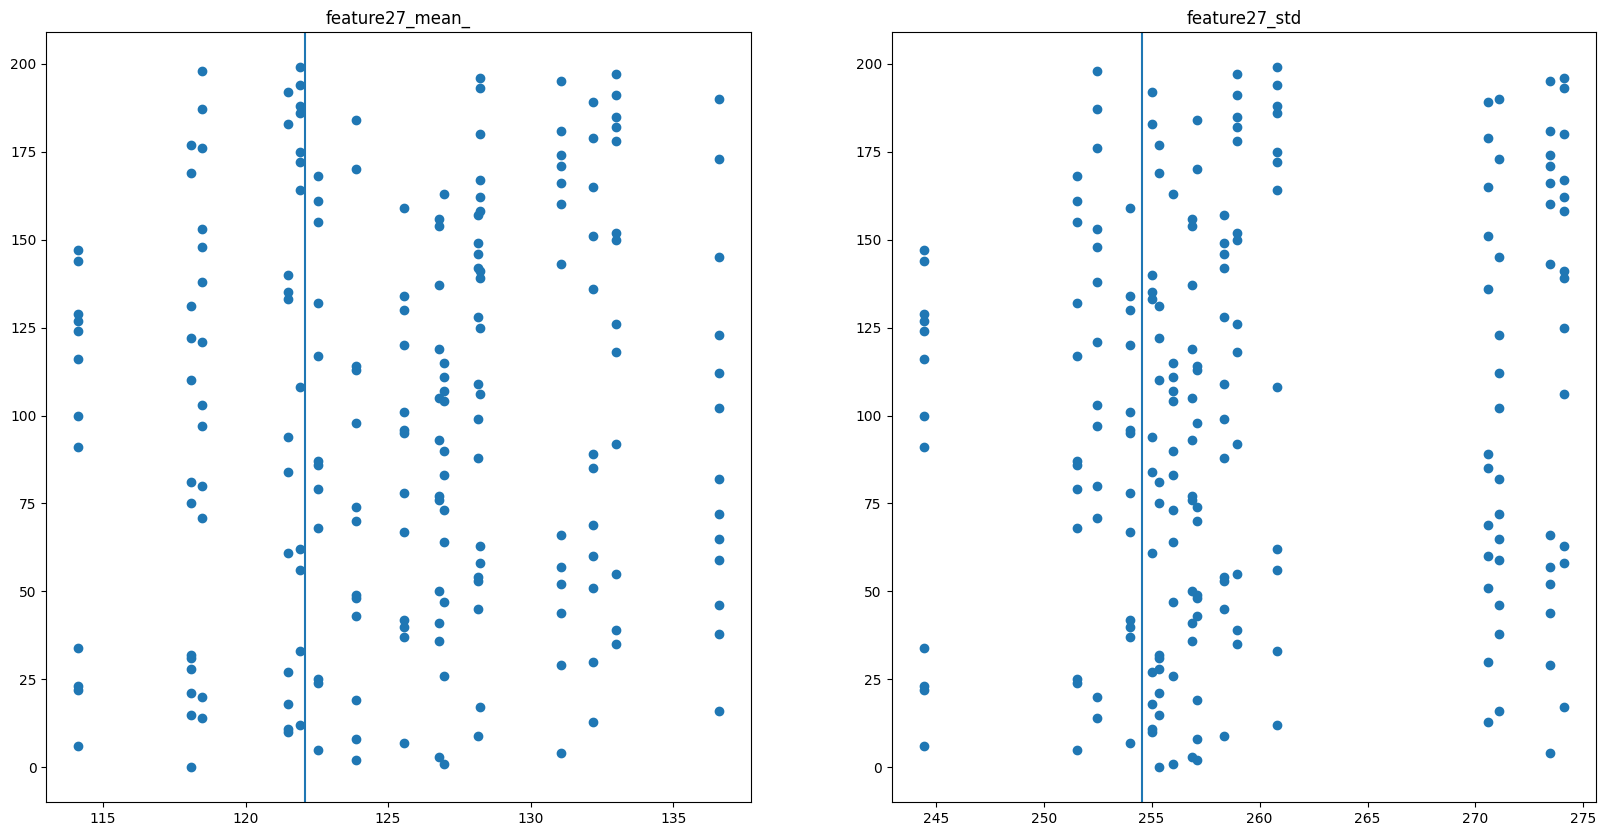

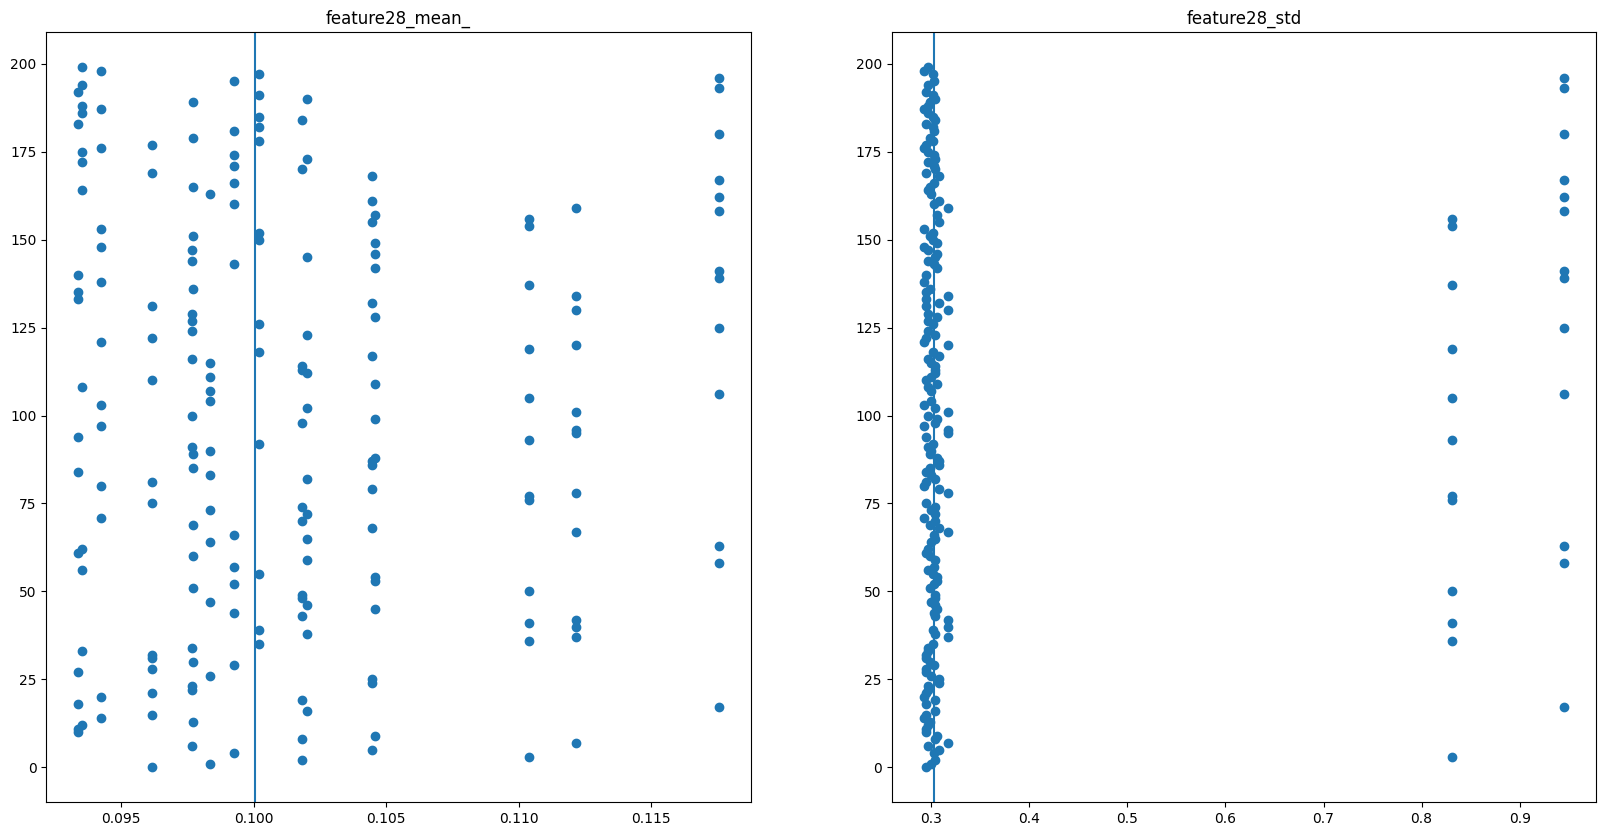

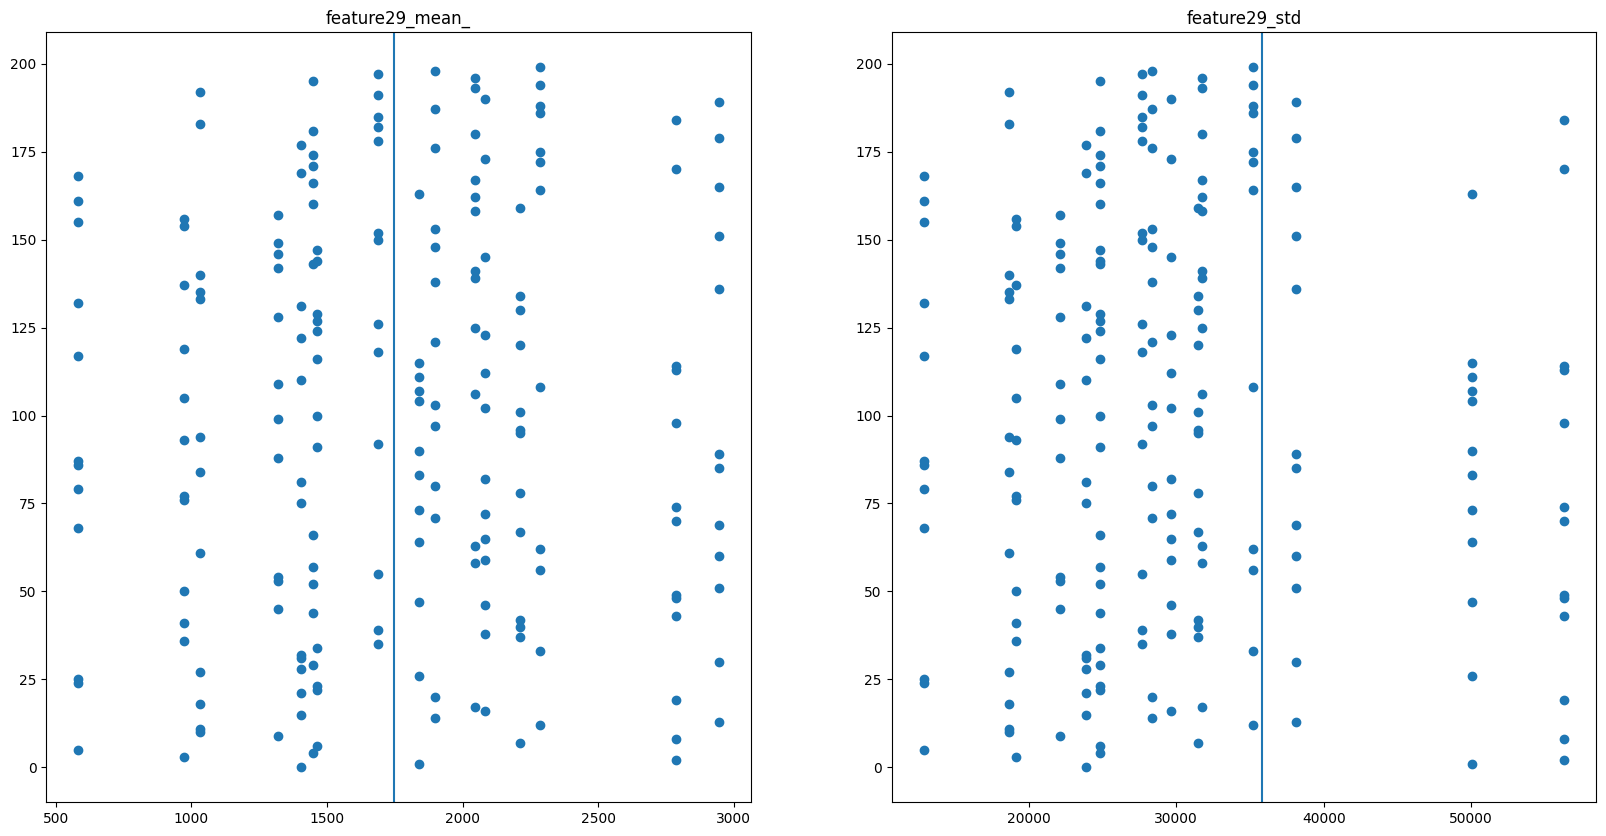

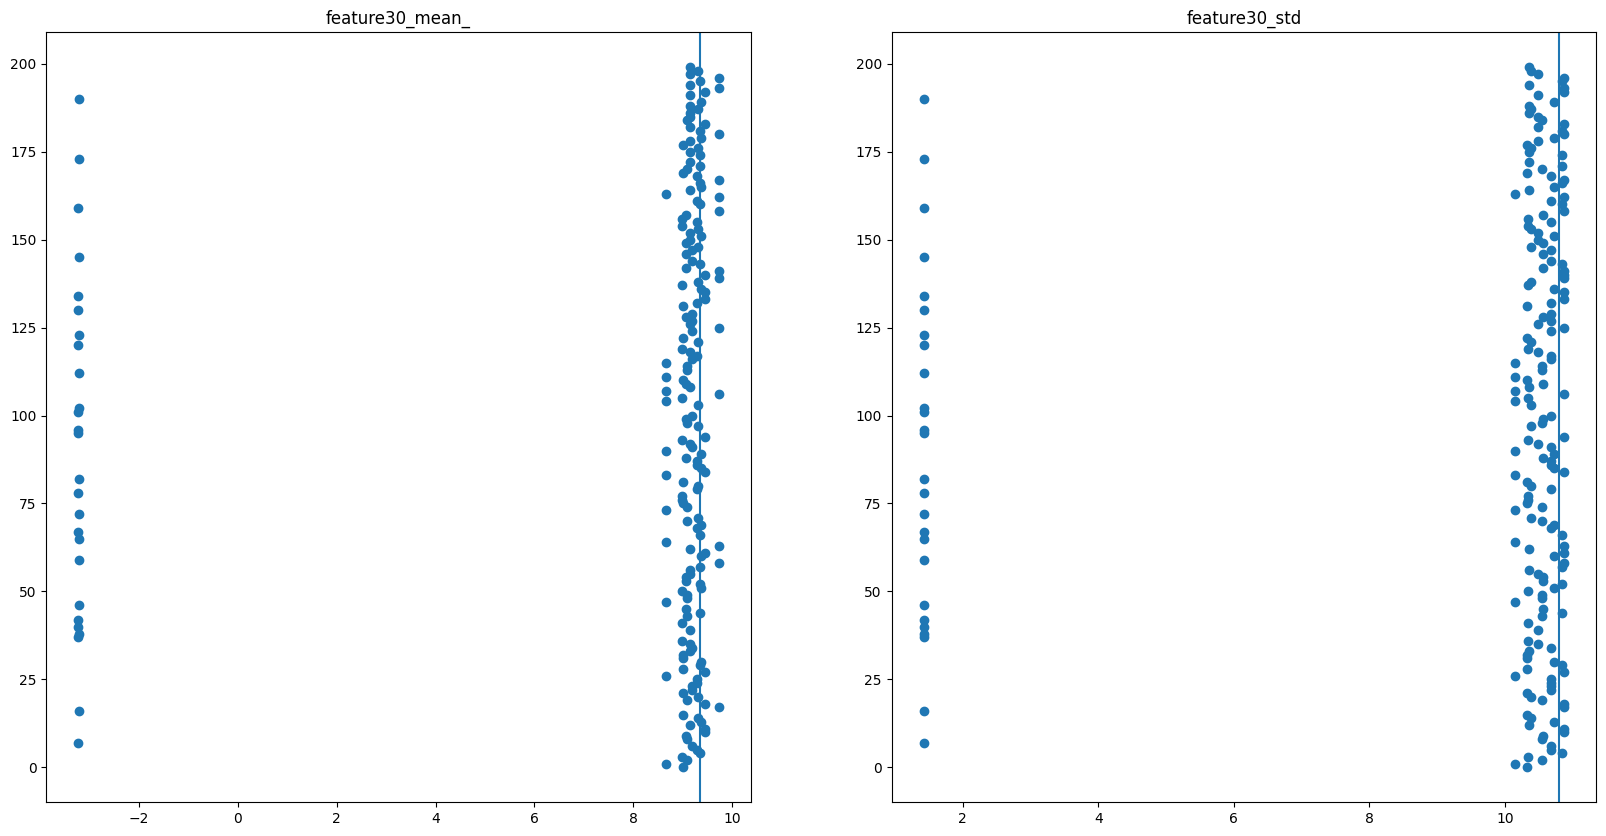

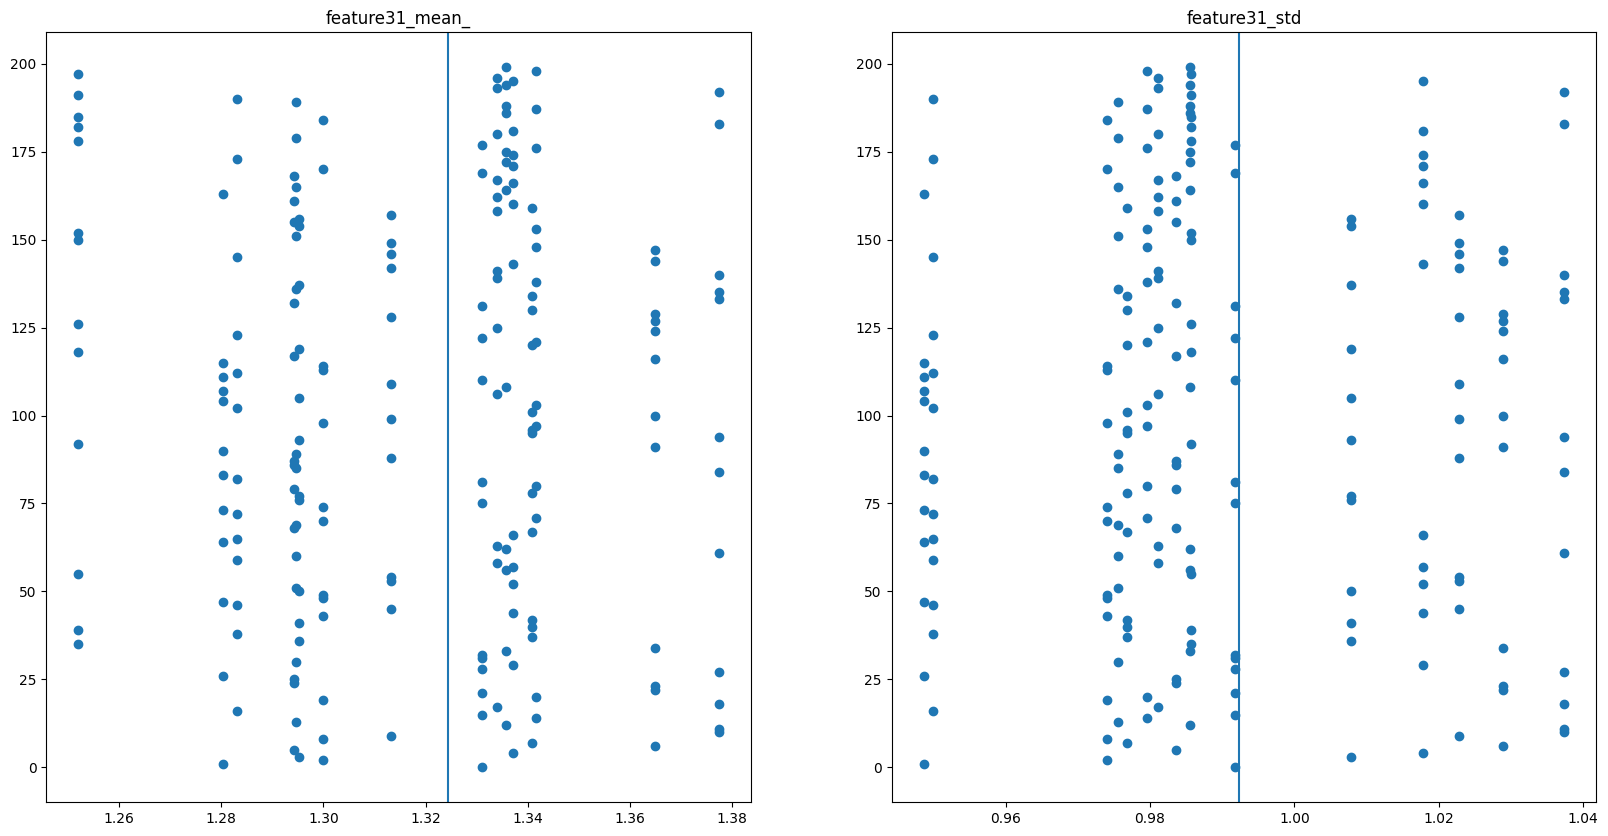

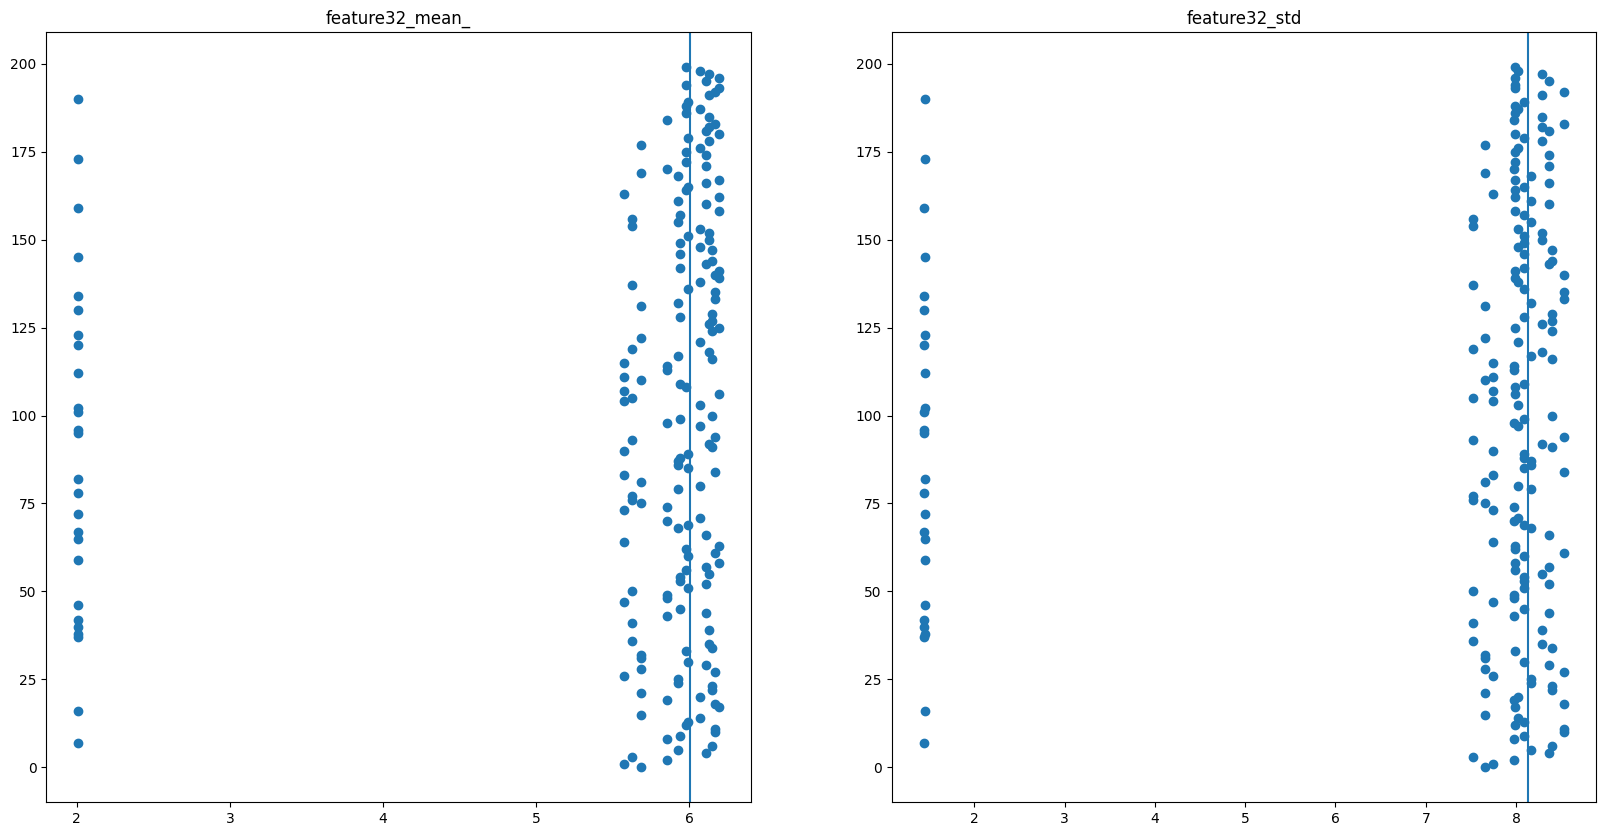

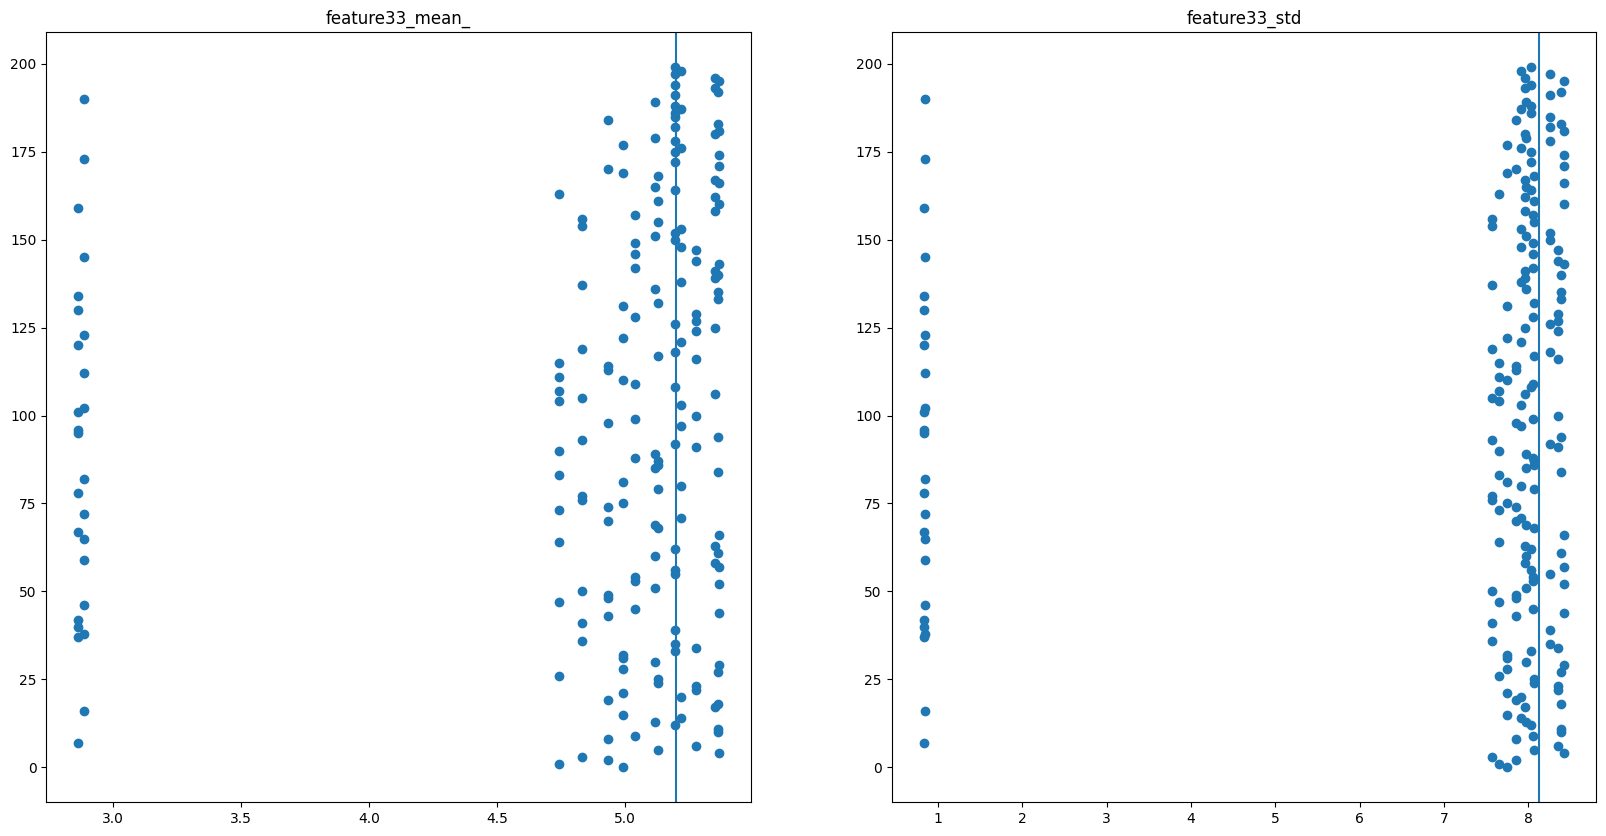

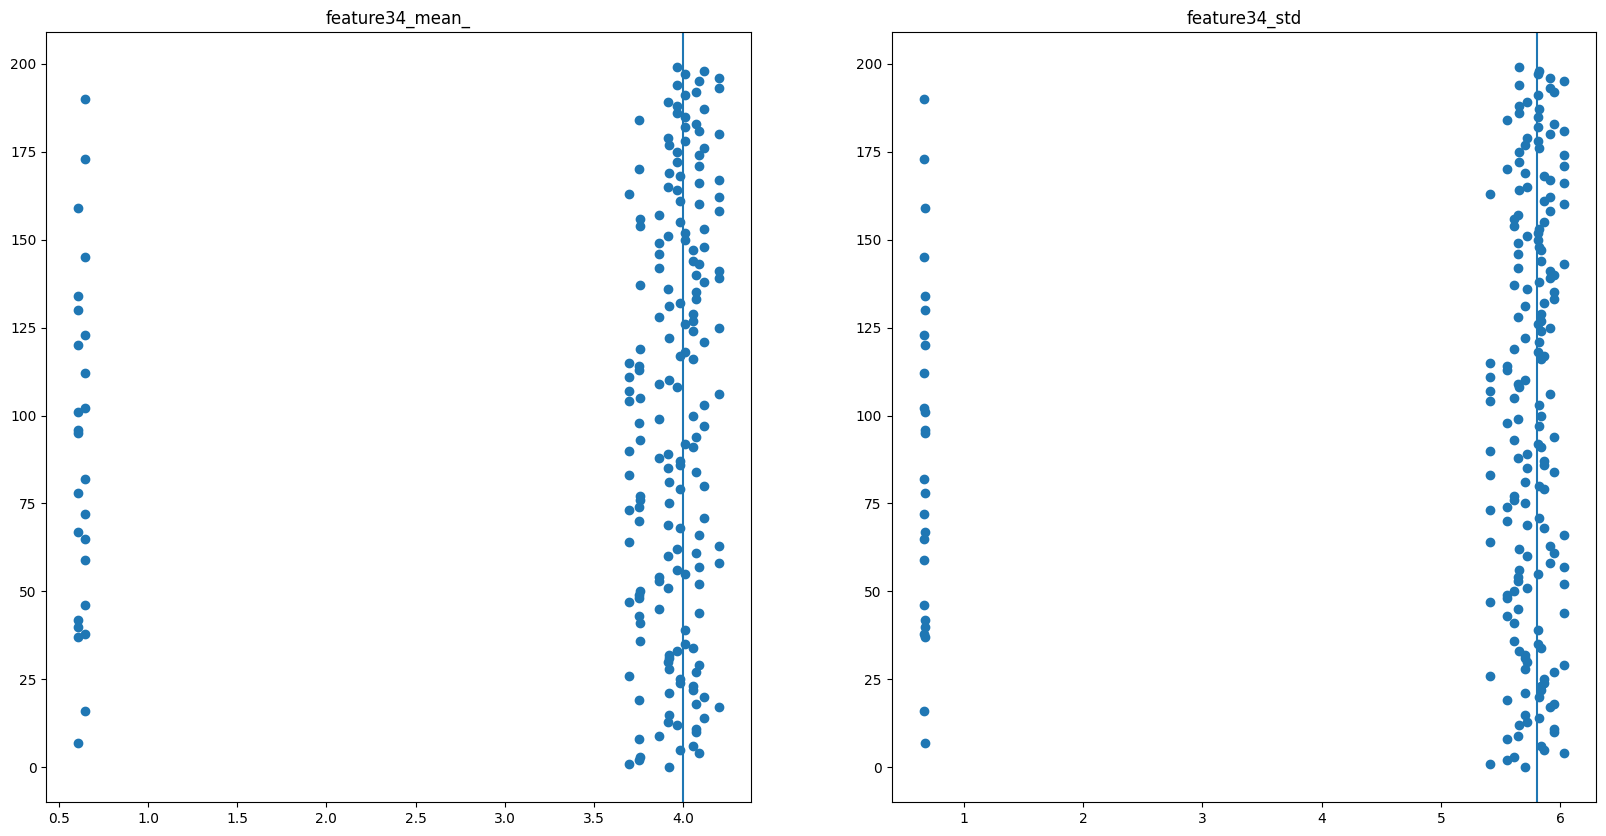

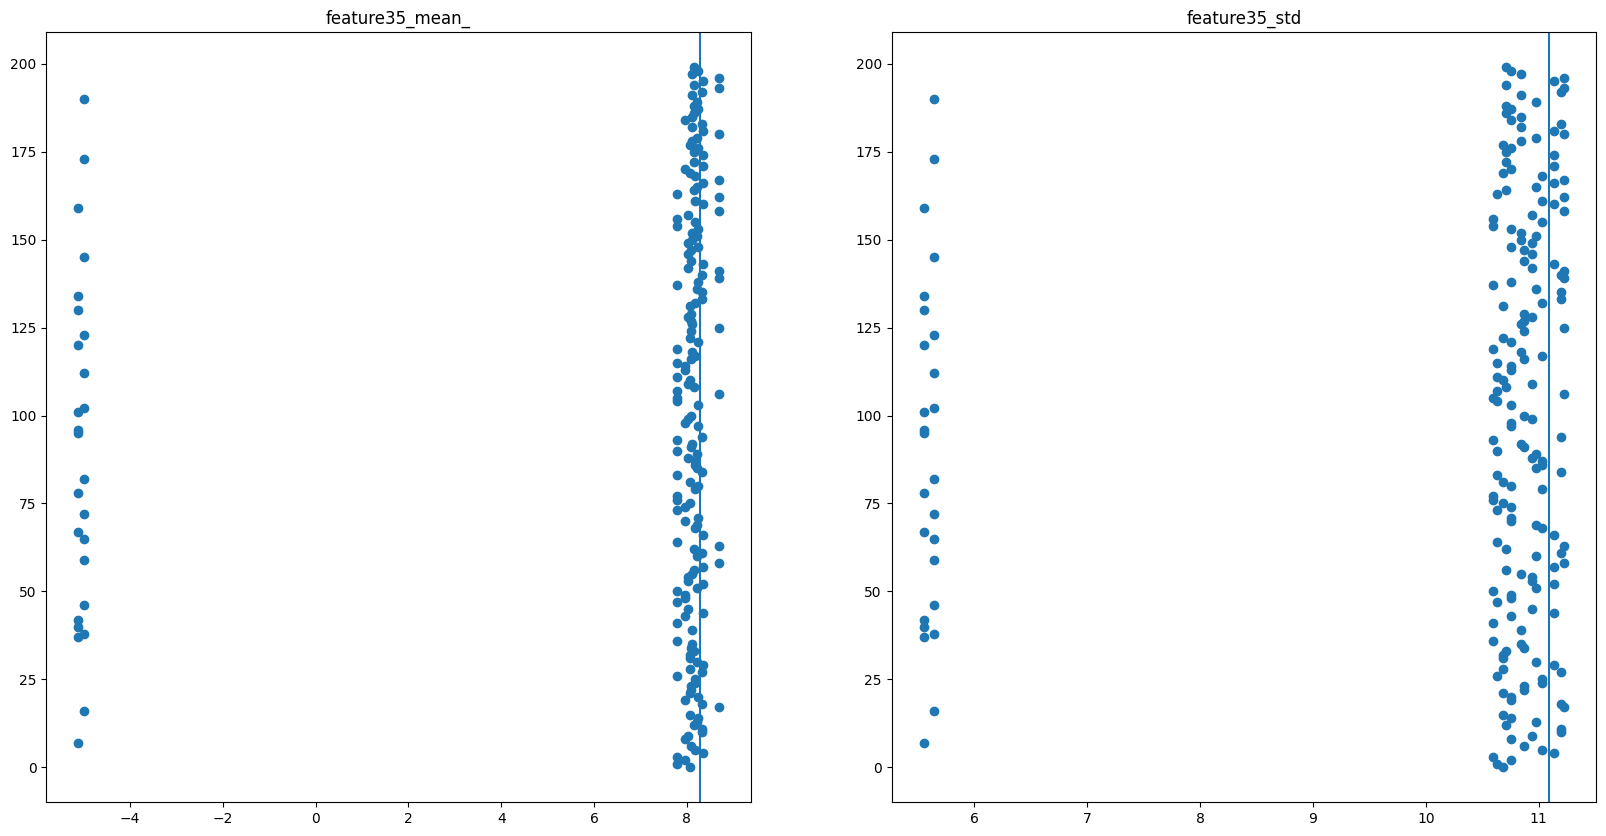

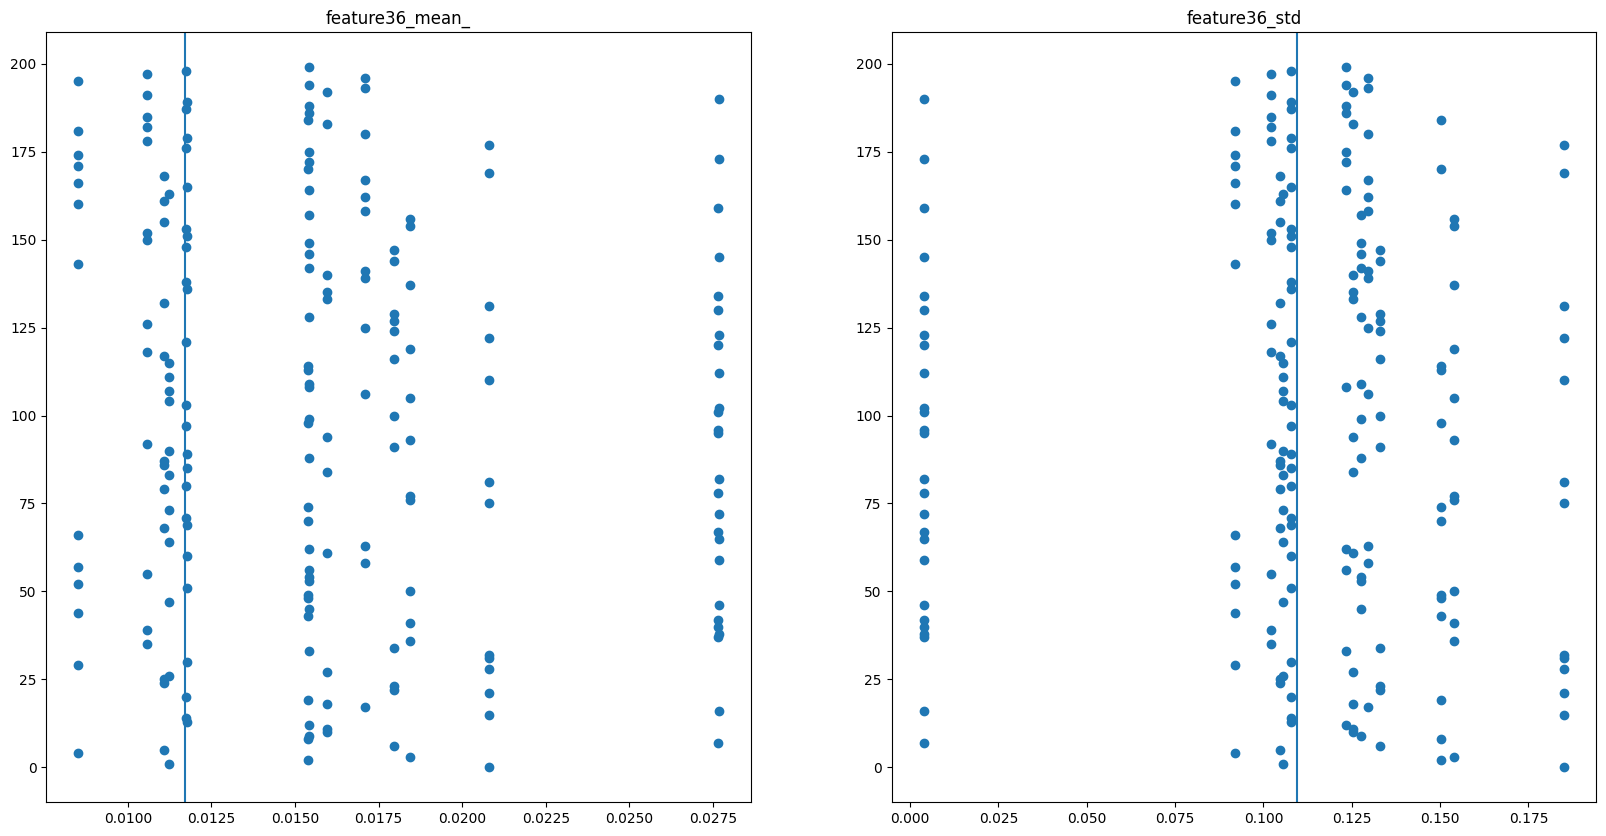

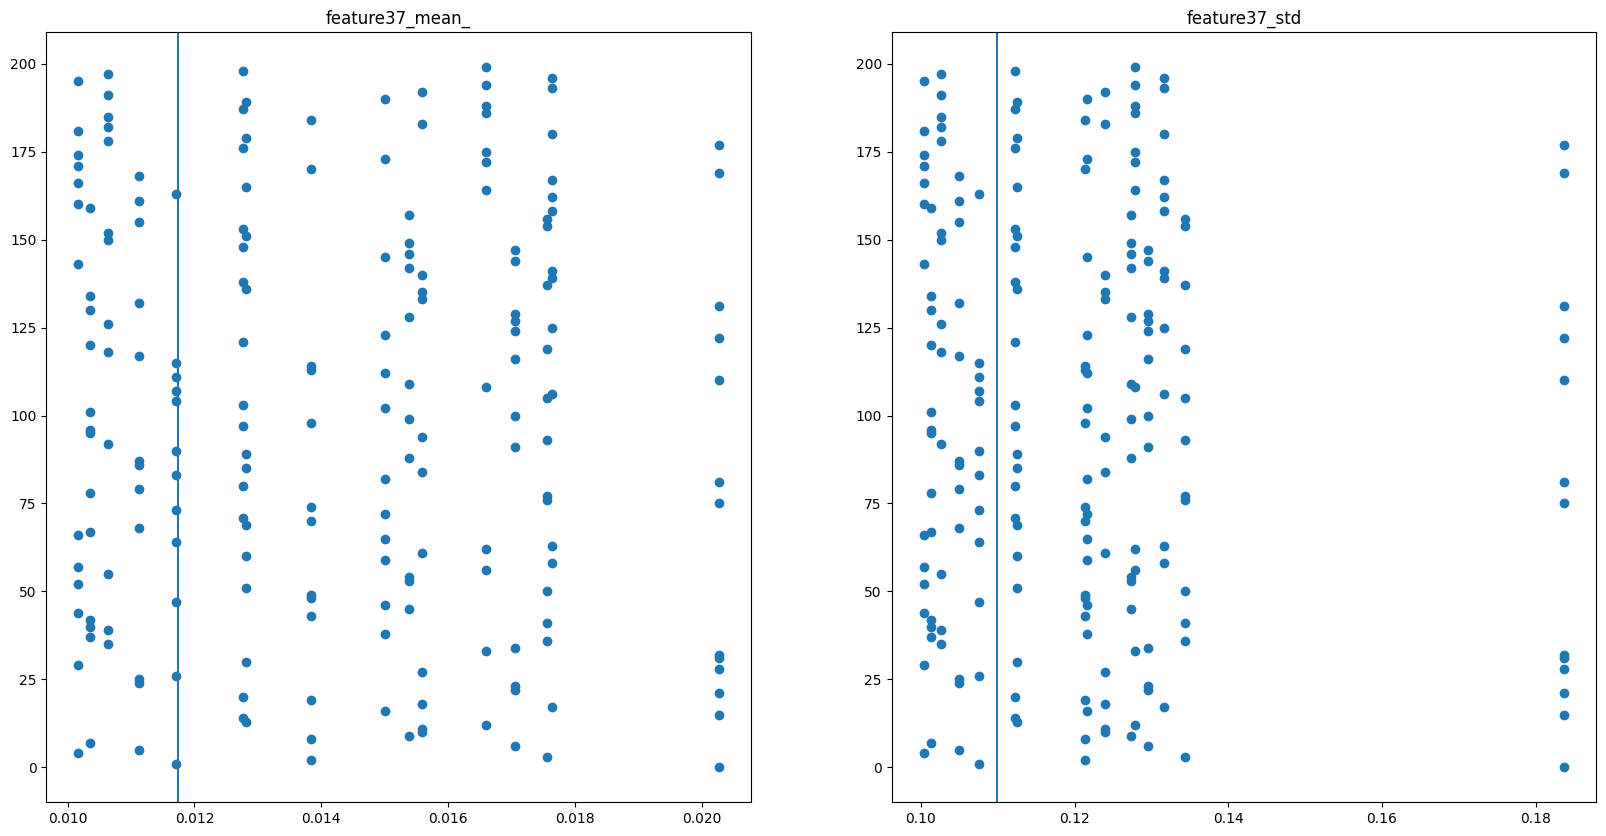

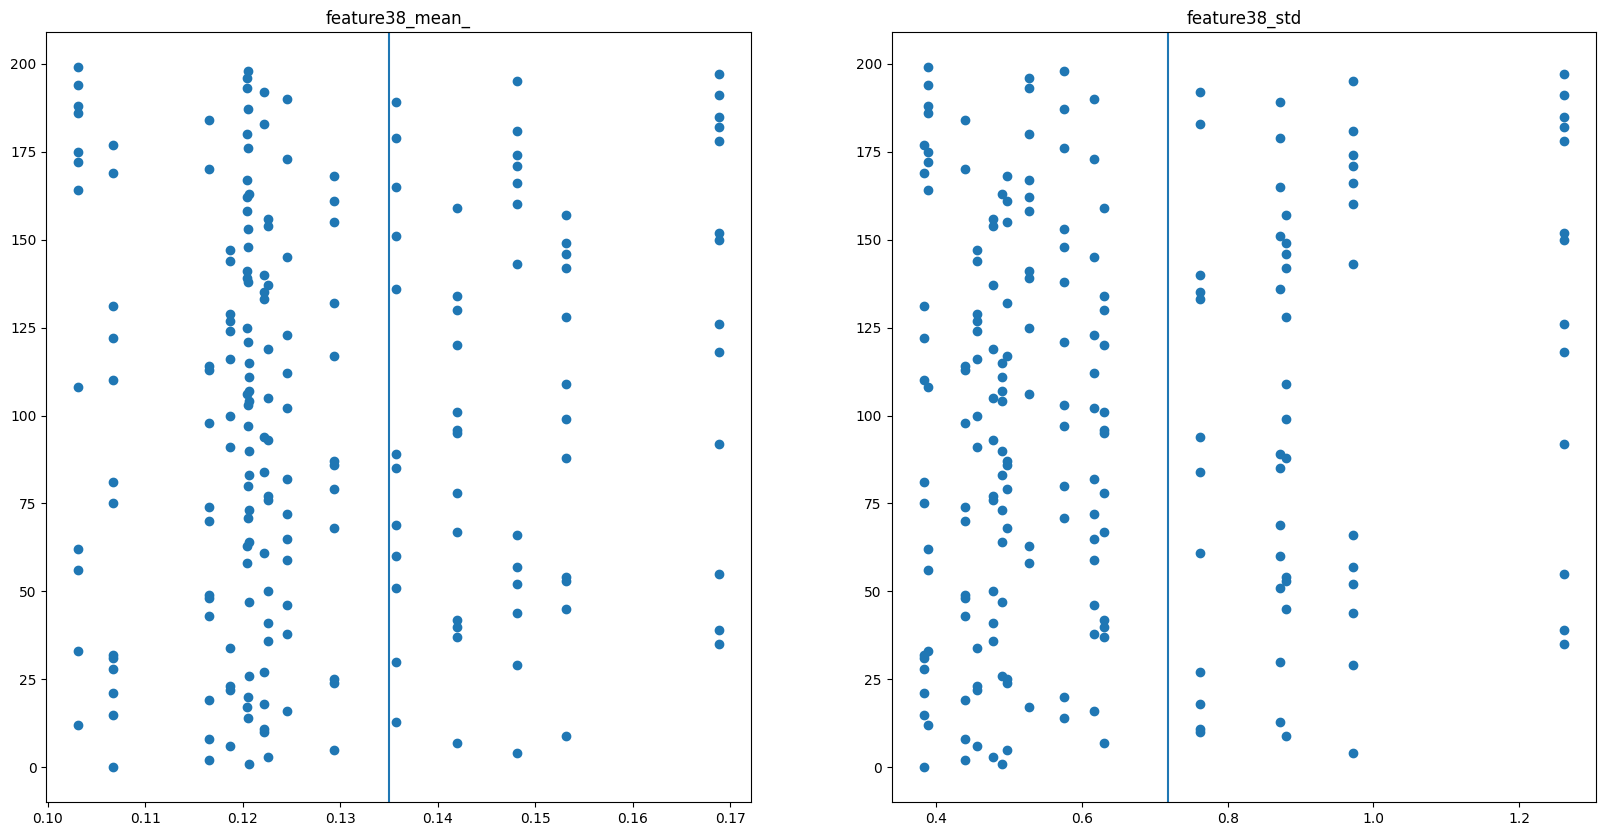

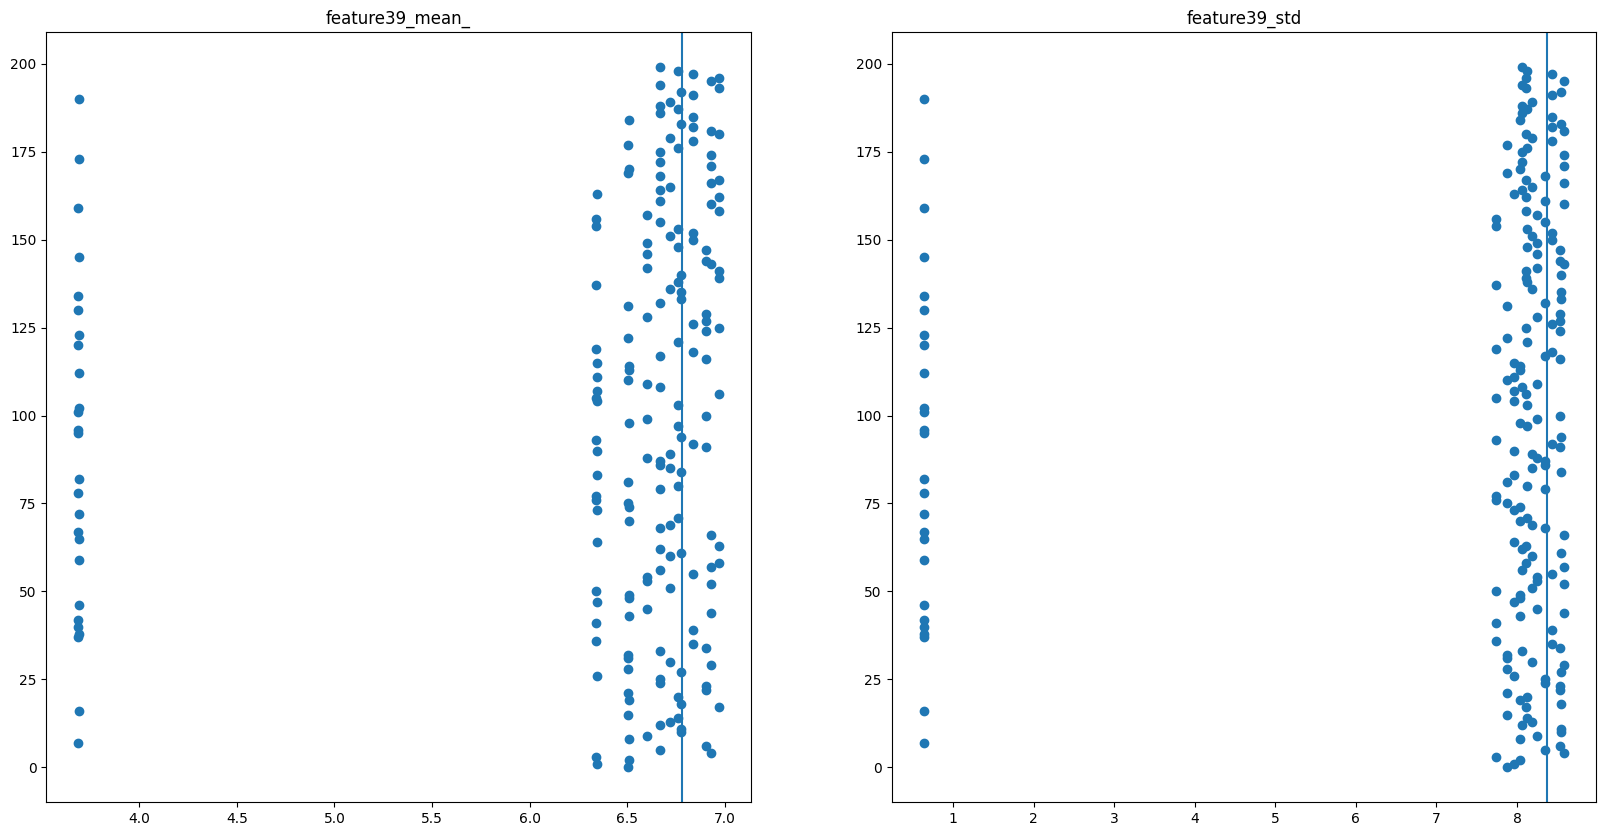

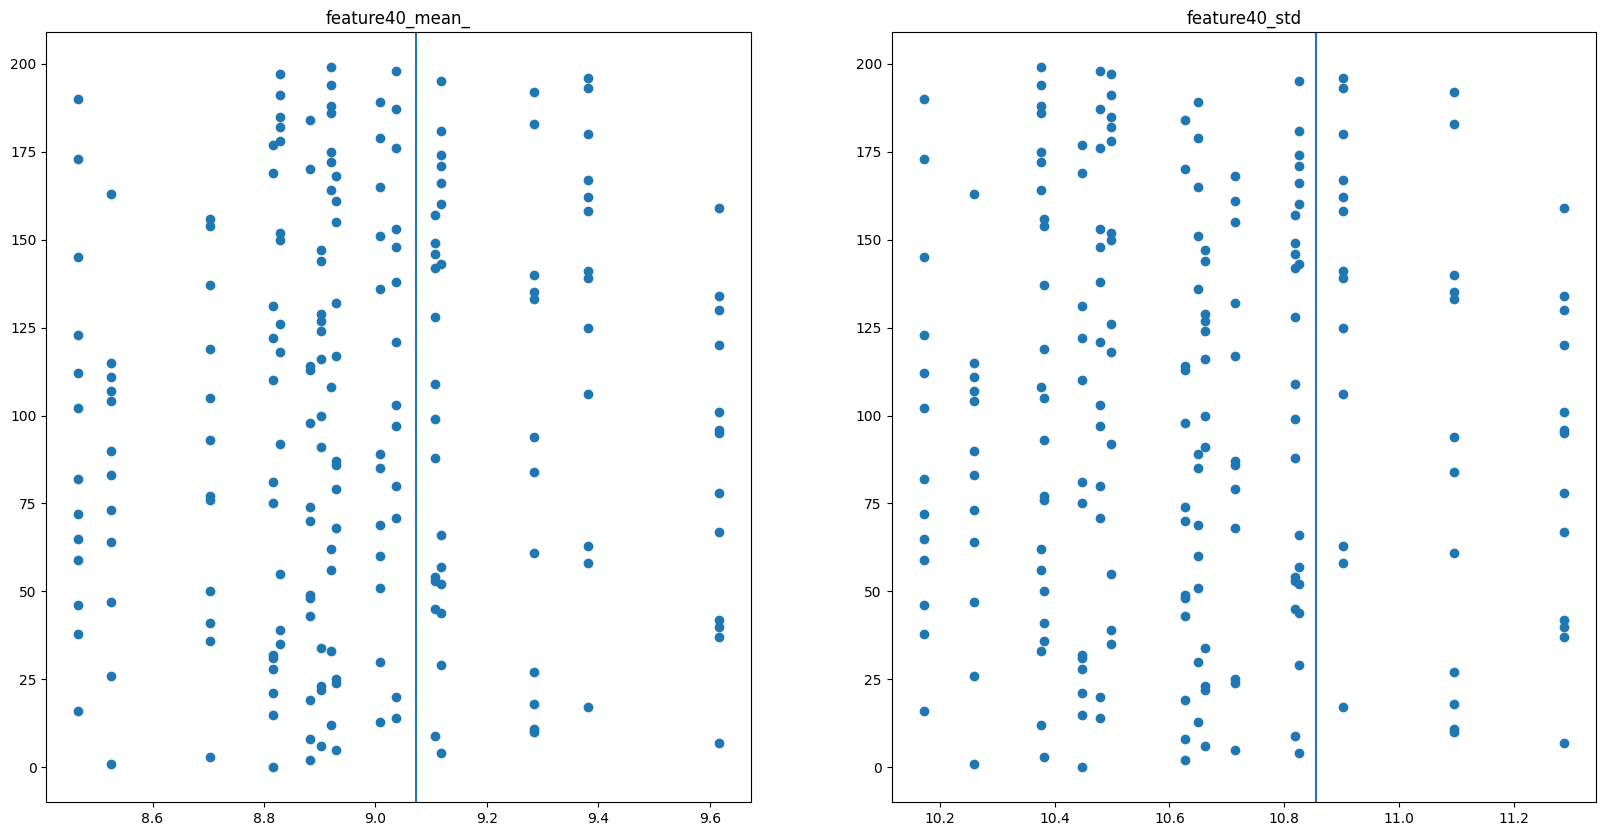

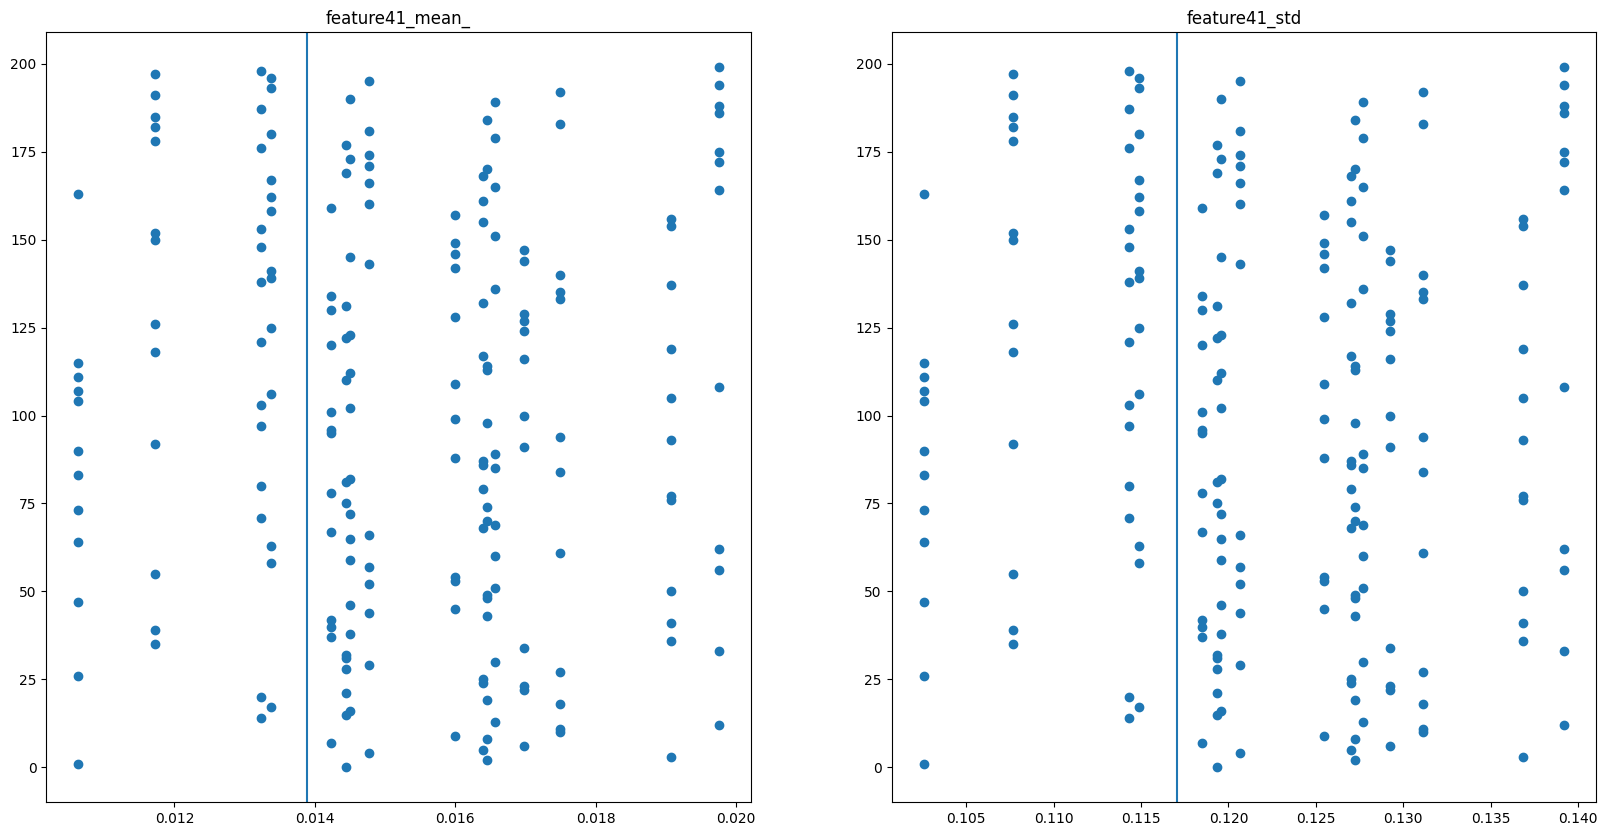

In [17]:
for col in check_drift.keys():
    stats = check_drift[col]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.scatter(x=stats['mean_'],y=stats.index)
    ax1.set_title(f'{col}_mean_')
    ax1.axvline(x=train_df[col].mean())

    ax2.scatter(x=stats['std_'],y=stats.index)
    ax2.set_title(f'{col}_std')
    ax2.axvline(x=train_df[col].std())
    plt.show()

In [34]:
from src.drift_detector import drift_psi

ModuleNotFoundError: No module named 'src.drift_detector'

In [21]:
for col in check_drift.keys():
    stats = check_drift[col]
    print(stats.n_max.sum(), stats.n_min.sum())

12 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
12 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
14 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
